<a href="https://colab.research.google.com/github/Smooj/Data-Science/blob/main/Tennis_Betting_Model_ATP_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# The Association of Tennis Professional Success Factors Analysis
---

The objective of this analysis is to see if certain factors correlate with proffessional male tennis player success. Specifically, the factors we analyzed were handedness, age, height, and rank of the player. As well as the surface the tournament is played on. To further our analysis, we also built a classification betting model.  

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
from statsmodels.stats.proportion import proportions_ztest
#from scipy.stats import binomtest
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import anderson
from scipy.stats import shapiro
!pip install scikit_posthocs
import scikit_posthocs as sp
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', None)

#Theme and font
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.6)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 43 kB 962 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37903 sha256=a32fa5fd9e592f1e807d36095a7b348eb19606898e70d2910fb0e7c092e224f8
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


# Importing Data:

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1i9O2SNodVeGaaStWiMWAA76-g5rnZf4x'})
downloaded.GetContentFile('ATP.csv')
df = pd.read_csv('ATP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   best_of             169690 non-null  int64  
 1   draw_size           1232 non-null    float64
 2   l_1stIn             83415 non-null   float64
 3   l_1stWon            83415 non-null   float64
 4   l_2ndWon            83415 non-null   float64
 5   l_SvGms             83415 non-null   float64
 6   l_ace               83415 non-null   float64
 7   l_bpFaced           83415 non-null   float64
 8   l_bpSaved           83415 non-null   float64
 9   l_df                83415 non-null   float64
 10  l_svpt              83415 non-null   float64
 11  loser_age           164700 non-null  float64
 12  loser_entry         25339 non-null   object 
 13  loser_hand          169605 non-null  object 
 14  loser_ht            139052 non-null  float64
 15  loser_id            169690 non-nul

In [ ]:
#changing the 'tourney_date' column into the format year, month, day
df['tourney_date'] = pd.to_datetime(df.tourney_date, format='%Y%m%d')
df = df.sort_values(['tourney_date'])

In [ ]:
df.head()

best_of  draw_size  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_ace  \
0         5       64.0      NaN       NaN       NaN      NaN    NaN   
33        5       64.0      NaN       NaN       NaN      NaN    NaN   
34        5       64.0      NaN       NaN       NaN      NaN    NaN   
35        5       64.0      NaN       NaN       NaN      NaN    NaN   
36        5       64.0      NaN       NaN       NaN      NaN    NaN   

    l_bpFaced  l_bpSaved  l_df  l_svpt  loser_age loser_entry loser_hand  \
0         NaN        NaN   NaN     NaN        NaN         NaN          R   
33        NaN        NaN   NaN     NaN        NaN         NaN          R   
34        NaN        NaN   NaN     NaN        NaN         NaN          R   
35        NaN        NaN   NaN     NaN  20.301164         NaN          R   
36        NaN        NaN   NaN     NaN  18.702259         NaN          R   

    loser_ht  loser_id loser_ioc       loser_name  loser_rank  \
0        NaN    107760       AUS       Max Senior         NaN   
33       NaN    107759       AUS      Max Pettman         NaN   
34       NaN    108519       AUS  William Coghlan         NaN   
35       NaN    100146       JPN   Jun Kamiwazumi         NaN   
36       NaN    100180       AUS       Bill Lloyd         NaN   

    loser_rank_points  loser_seed  match_num  minutes round  \
0                 NaN         NaN          1      NaN   R64   
33                NaN         NaN         34      NaN   R32   
34                NaN         NaN         35      NaN   R32   
35                NaN        16.0         36      NaN   R32   
36                NaN         NaN         37      NaN   R32   

                      score surface tourney_date tourney_id tourney_level  \
0         12-10 7-5 4-6 7-5   Grass   1968-01-19   1968-580             G   
33              6-1 6-3 6-2   Grass   1968-01-19   1968-580             G   
34  6-2 6-4 3-6 5-7 4-2 RET   Grass   1968-01-19   1968-580             G   
35              6-2 6-2 6-1   Grass   1968-01-19   1968-580             G   
36      6-4 3-6 8-6 4-6 6-3   Grass   1968-01-19   1968-580             G   

        tourney_name  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_ace  w_bpFaced  \
0   Australian Chps.      NaN       NaN       NaN      NaN    NaN        NaN   
33  Australian Chps.      NaN       NaN       NaN      NaN    NaN        NaN   
34  Australian Chps.      NaN       NaN       NaN      NaN    NaN        NaN   
35  Australian Chps.      NaN       NaN       NaN      NaN    NaN        NaN   
36  Australian Chps.      NaN       NaN       NaN      NaN    NaN        NaN   

    w_bpSaved  w_df  w_svpt  winner_age winner_entry winner_hand  winner_ht  \
0         NaN   NaN     NaN         NaN          NaN           R        NaN   
33        NaN   NaN     NaN   22.557153          NaN           R        NaN   
34        NaN   NaN     NaN   30.529774          NaN           R      173.0   
35        NaN   NaN     NaN   34.001369          NaN           R        NaN   
36        NaN   NaN     NaN   34.294319          NaN           L        NaN   

    winner_id winner_ioc           winner_name  winner_rank  \
0      110023        AUS     Richard Coulthard          NaN   
33     100101        CAN           Mike Belkin          NaN   
34     100025        AUS  Barry Phillips Moore          NaN   
35     109799        AUS         Geoff Pollard          NaN   
36     100013        AUS          Neale Fraser          NaN   

    winner_rank_points  winner_seed  
0                  NaN          NaN  
33                 NaN         12.0  
34                 NaN          3.0  
35                 NaN          NaN  
36                 NaN          NaN

In [ ]:
df.shape

(169690, 49)

In [ ]:
df.columns

Index(['best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age',
       'loser_entry', 'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc',
       'loser_name', 'loser_rank', 'loser_rank_points', 'loser_seed',
       'match_num', 'minutes', 'round', 'score', 'surface', 'tourney_date',
       'tourney_id', 'tourney_level', 'tourney_name', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df',
       'w_svpt', 'winner_age', 'winner_entry', 'winner_hand', 'winner_ht',
       'winner_id', 'winner_ioc', 'winner_name', 'winner_rank',
       'winner_rank_points', 'winner_seed'],
      dtype='object')

**Description of attribute names:**

---
**Tournament Information**

• tourney_id - tournament id

• tourney_name - tournament name

• surface - surface in which the match is played

• tourney_date - starting date of the tournament

• tourney_level - tournament level

• round - the round in the tournament a match belongs to

• match num - match number in a certain tournament

• best_of - the maximum number of sets played

• rank_points - points accumulated per tournament and is tournament specific

**Player Infromation– These columns are repeated for winner and loser**

• id - player id

• seed - the seed of the player in that tournament

• entry - How did the player enter the tournaments?

• name - player name

• hand - hand of the player, right or left

• ht - the height of the player

• IOC - the country of origin

• age - age of the player

• rank - ATP overall ranking of the player

**Player Match Statistics – These columns are repeated for winner and loser**

• draw_size - the size of the draw


• 1stin - first serve in percent (winners & losers)

• 1stWon - first serve winning percent (winners & losers)

• 2ndWon - second serve winning percent (winners & losers)

• SvGms - number of games played on serve (So, the maximum difference between wSvGms and lSvGms will be 1) (winners & losers)

• ace - number of aces in the match (winners & losers)

• bpSaved - breakpoints saved (winners & losers)

• bpFaced - breakpoints faced (winners & losers)

• df - double faults (winners & losers)

• svpt - serve percent (winners & losers)


• score - final score in the match

• minutes - duration of the match in minutes

In [ ]:
df.describe()

best_of    draw_size       l_1stIn      l_1stWon      l_2ndWon  \
count  169690.000000  1232.000000  83415.000000  83415.000000  83415.000000   
mean        3.446072    75.022727     47.705149     31.683690     15.029119   
std         0.832567    43.500071     19.359849     14.437267      7.266522   
min         3.000000     4.000000      0.000000      0.000000      0.000000   
25%         3.000000    64.000000     34.000000     21.000000     10.000000   
50%         3.000000    64.000000     44.000000     29.000000     14.000000   
75%         3.000000   128.000000     58.000000     39.000000     19.000000   
max         5.000000   128.000000    328.000000    284.000000    101.000000   

            l_SvGms         l_ace     l_bpFaced     l_bpSaved          l_df  \
count  83415.000000  83415.000000  83415.000000  83415.000000  83415.000000   
mean      12.159995      4.779776      8.751555      4.808044      3.509081   
std        4.114587      4.625035      4.123616      3.271050      2.623945   
min        0.000000      0.000000      0.000000     -6.000000      0.000000   
25%        9.000000      2.000000      6.000000      2.000000      2.000000   
50%       11.000000      4.000000      8.000000      4.000000      3.000000   
75%       15.000000      7.000000     11.000000      7.000000      5.000000   
max       91.000000    103.000000     35.000000     28.000000     26.000000   

             l_svpt      loser_age       loser_ht       loser_id  \
count  83415.000000  164700.000000  139052.000000  169690.000000   
mean      80.717904      25.661378     184.064918  102829.308574   
std       29.485231       4.074386       6.624417    6072.998247   
min        0.000000      14.380000     160.000000  100001.000000   
25%       59.000000      22.750000     180.000000  100529.000000   
50%       75.000000      25.320000     185.000000  101736.000000   
75%       96.000000      28.250000     188.000000  103821.000000   
max      489.000000      63.690000     208.000000  208997.000000   

          loser_rank  loser_rank_points    loser_seed      match_num  \
count  145909.000000       93025.000000  32853.000000  169690.000000   
mean      120.815721         840.134727      7.589109      52.853492   
std       161.539365         940.800241      5.880047      81.992868   
min         1.000000           1.000000      1.000000       1.000000   
25%        40.000000         367.000000      4.000000       9.000000   
50%        77.000000         618.000000      6.000000      22.000000   
75%       134.000000         985.000000     10.000000      45.000000   
max      2159.000000       16950.000000     35.000000     701.000000   

            minutes       w_1stIn      w_1stWon      w_2ndWon       w_SvGms  \
count  82103.000000  83415.000000  83415.000000  83415.000000  83415.000000   
mean     100.786037     47.299514     35.659522     16.806102     12.354780   
std       40.332392     19.191976     13.841457      7.026601      4.102224   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       73.000000     33.000000     26.000000     12.000000      9.000000   
50%       94.000000     44.000000     33.000000     16.000000     11.000000   
75%      123.000000     57.000000     43.000000     21.000000     15.000000   
max     1146.000000    361.000000    292.000000     82.000000     90.000000   

              w_ace     w_bpFaced     w_bpSaved          w_df        w_svpt  \
count  83415.000000  83415.000000  83415.000000  83415.000000  83415.000000   
mean       6.461823      5.174381      3.528790      2.743859     77.906887   
std        5.297845      4.058311      3.081844      2.368677     29.532338   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      2.000000      1.000000      1.000000     56.000000   
50%        5.000000      4.000000      3.000000      2.000000     73.000000   
75%        9.000000      7.000000      5.000000      4.000000 

# Data Exploration and Visualization:

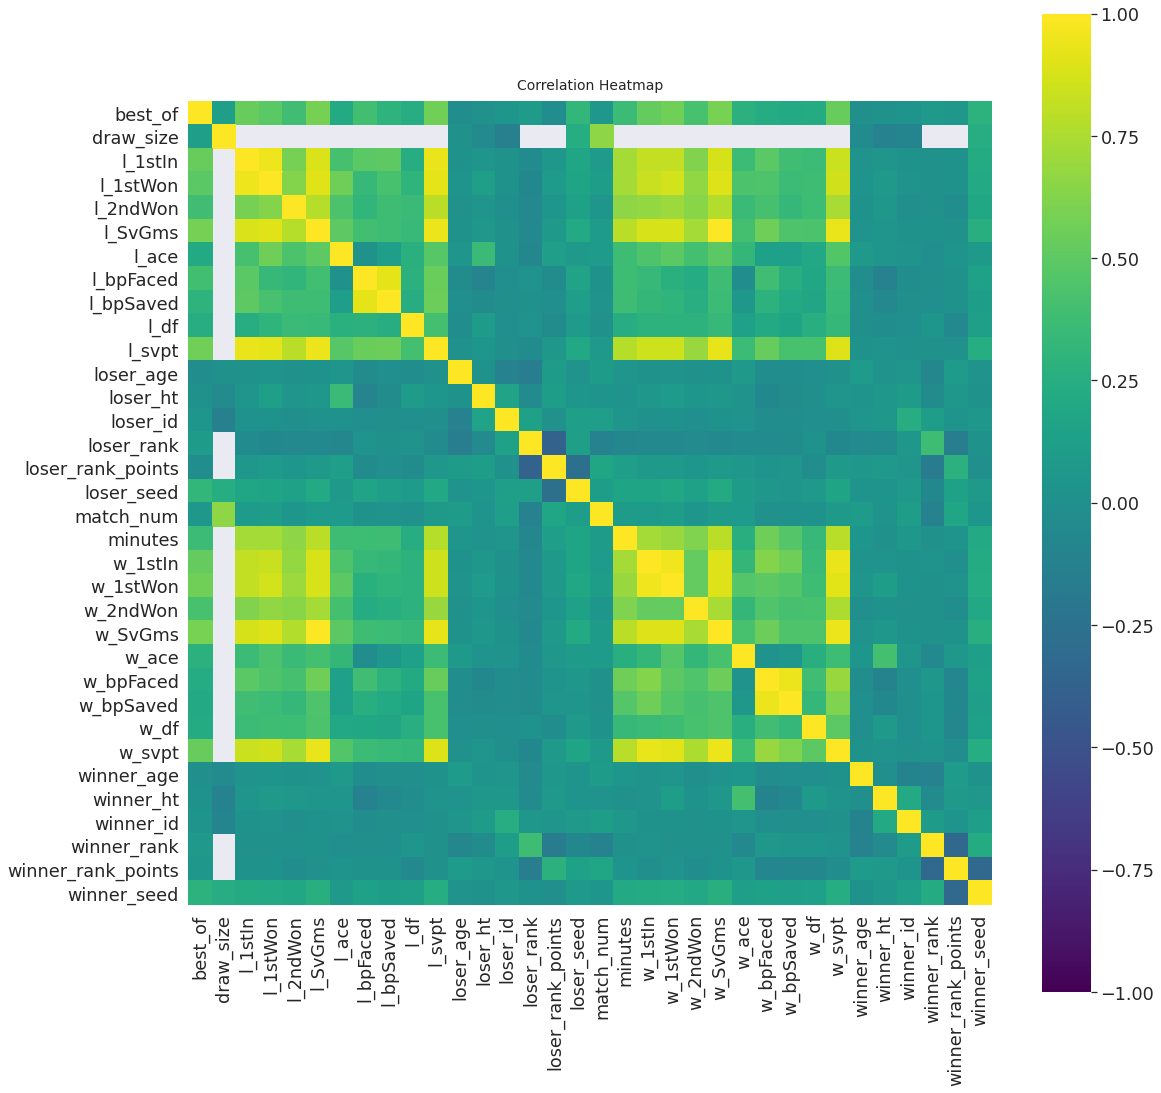

In [ ]:
#correlation heatmap
plt.figure(figsize=(18,18))

heatmap = sns.heatmap(df.corr(),
        #annot = True, #if True, display the correlation values on the heatmap (i.e. in each cell)
        square = True, #if True, the axes aspect will be “equal” so each cell will be square-shaped
        cmap = "viridis", #matplotlib colormap name
        vmin = -1, #set the range of values to be displayed on the colormap from -1 to 1
        vmax = 1,
        annot_kws = {'size':15}) #keyword arguments for axes text when annot is True

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12); #pad = distance of the title from the top of the heatmap

plt.show()

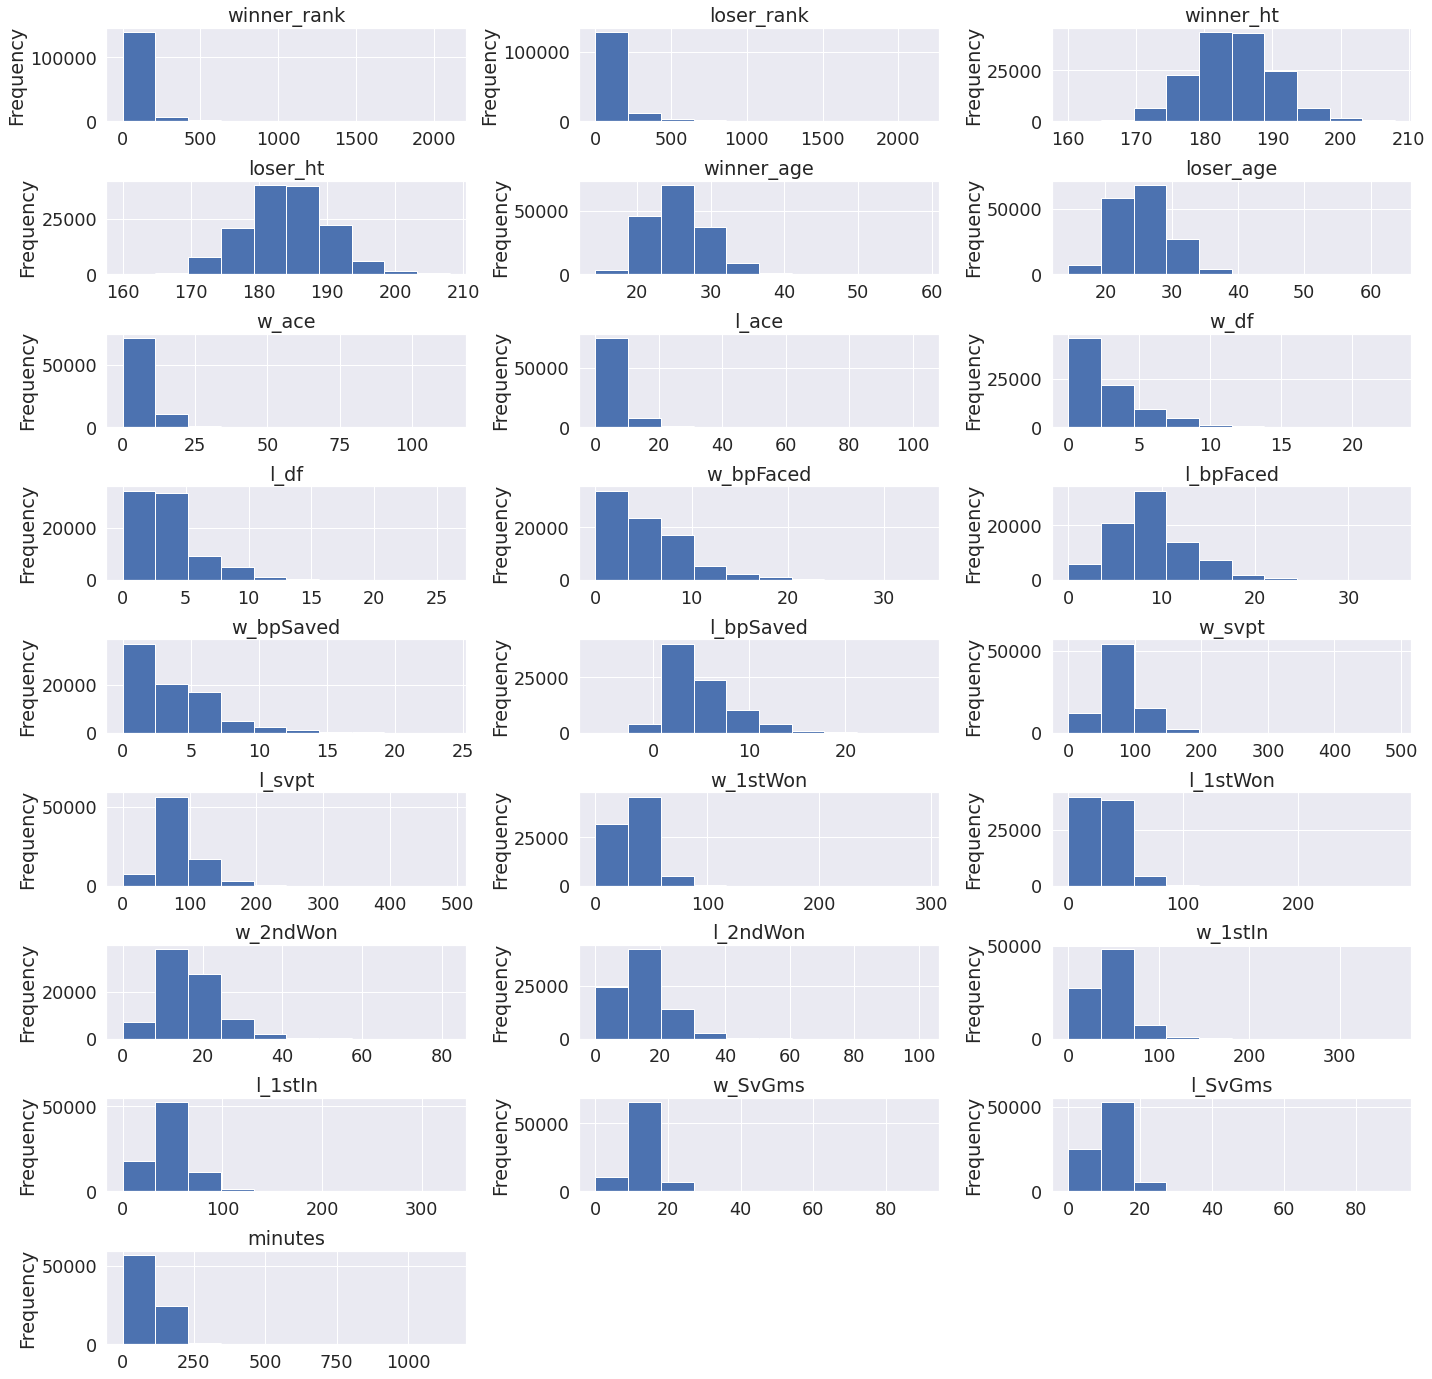

In [ ]:
#Continuous Data
hist_plots = ['winner_rank','loser_rank','winner_ht','loser_ht','winner_age','loser_age','w_ace',
              'l_ace','w_df','l_df','w_bpFaced','l_bpFaced','w_bpSaved','l_bpSaved','w_svpt',
              'l_svpt','w_1stWon','l_1stWon','w_2ndWon','l_2ndWon','w_1stIn','l_1stIn',
              'w_SvGms','l_SvGms','minutes']
plt.figure(1,figsize=(20,21))
for i in range(1,26):
    plt.subplot(10,3,i)
    df[hist_plots[i-1]].plot(kind='hist',title=hist_plots[i-1])
plt.tight_layout()

- Height is the only numerical column that looks normally distributed.
- Other columns are also right skewed
- All non-normal columns except for age contain 0 values. Thus, log transfromation cannot be used so square root transfromation will be used.

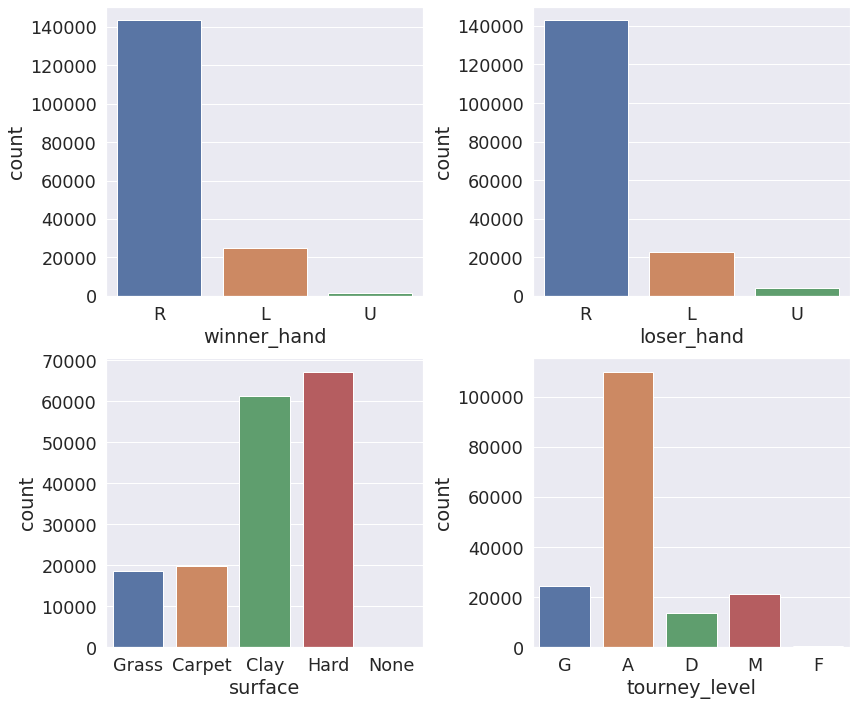

In [ ]:
#Categorical Data:
count_plts = ['winner_hand','loser_hand','surface','tourney_level']
plt.figure(1,figsize=(12,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    sns.countplot(x=df[count_plts[i-1]])
plt.tight_layout()
None

### **Country**

In [ ]:
Countries = pd.concat([df.winner_ioc, df.loser_ioc], axis=0)
Countries.unique()

array(['AUS', 'CAN', 'ESP', 'GBR', 'JPN', 'USA', 'IND', 'DEN', 'BRA',
       'FRA', 'UNK', 'CZE', 'GRE', 'EGY', 'BEL', 'SRI', 'MAS', 'CHI',
       'ITA', 'UKR', 'POL', 'COL', 'RUS', 'HUN', 'ROU', 'GER', 'RSA',
       'PHI', 'MON', 'IRL', 'ARG', 'VEN', 'BUL', 'CRO', 'NOR', 'POR',
       'FIN', 'NED', 'LUX', 'ISR', 'IRI', 'SWE', 'RHO', 'NZL', 'MEX',
       'ECU', 'SRB', 'SUI', 'PER', 'ZIM', 'AUT', 'JAM', 'VIE', 'KOR',
       'CAR', 'PAK', 'TCH', 'INA', 'TUR', 'MAR', 'URS', 'CRC', 'LIB',
       'NGR', 'NIG', 'PAR', 'BOL', 'YUG', 'URU', 'UAE', 'THA', 'ALG',
       'BAH', 'TPE', 'PUR', 'CHN', 'HKG', 'SVK', 'BAR', 'TUN', 'SEN',
       'SIN', 'CYP', 'KEN', 'CUB', 'CIV', 'MLT', 'GHA', 'BAN', 'SYR',
       'KUW', 'JOR', 'IRQ', 'BRN', 'DOM', 'CMR', 'HAI', 'ZAM', 'TOG',
       'GUA', 'ESA', 'ECA', 'LAT', 'KSA', 'GEO', 'ARM', 'SLO', 'EST',
       'UZB', 'LTU', 'BLR', 'MKD', 'BIH', 'QAT', 'KAZ', 'AHO', 'MDA',
       'TJK', 'AND', 'SOL', 'SAM', 'MHL', 'OMA', 'MNE', 'MAD', 'GUM',
       'BEN', 'BER',

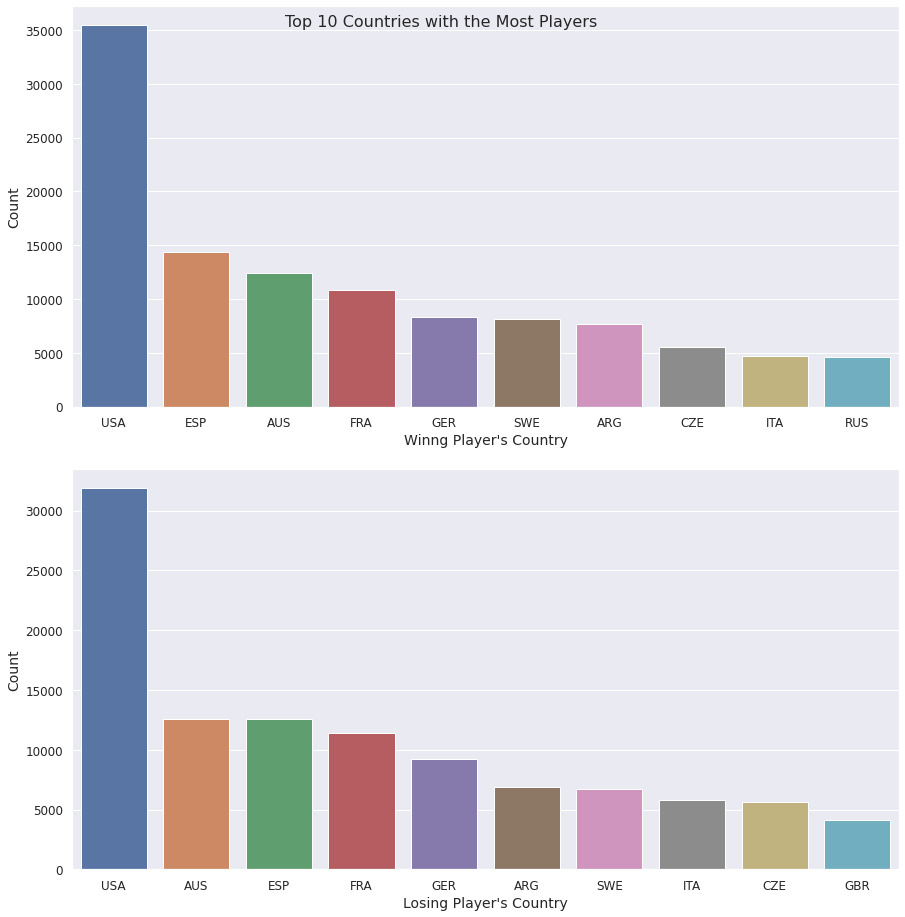

In [ ]:
fig, ax = plt.subplots(2,figsize=(13, 13))
sns.countplot(ax= ax[0], x='winner_ioc', data = df, order=df.winner_ioc.value_counts().iloc[:10].index)
sns.countplot(ax= ax[1], x='loser_ioc', data = df, order=df.loser_ioc.value_counts().iloc[:10].index)
plt.tight_layout()
ax[0].set_ylabel("Count", fontsize=14)
ax[0].xaxis.set_label_text("Winng Player's Country", fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_ylabel("Count", fontsize=14)
ax[1].xaxis.set_label_text("Losing Player's Country", fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
fig.suptitle('Top 10 Countries with the Most Players', fontsize=16);

### **Player's Name**

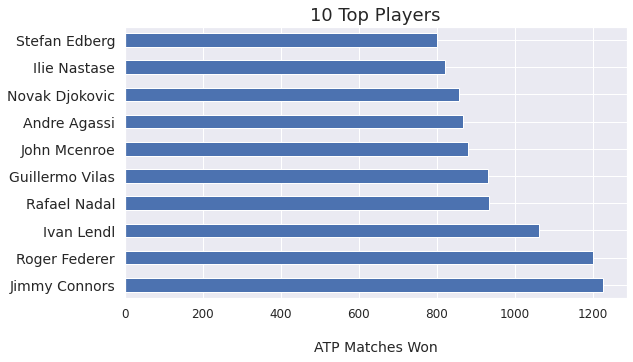

In [ ]:
plt.figure(figsize=(9,5))
df['winner_name'].value_counts()[:10].plot(kind='barh')
plt.title('10 Top Players', fontsize=18)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('ATP Matches Won', size=14, labelpad=20);
#the players who have won the most ATP matches are also most likely to continue winning (if they are still playing)

# Data Cleaning:

### **Normalizing the data:**

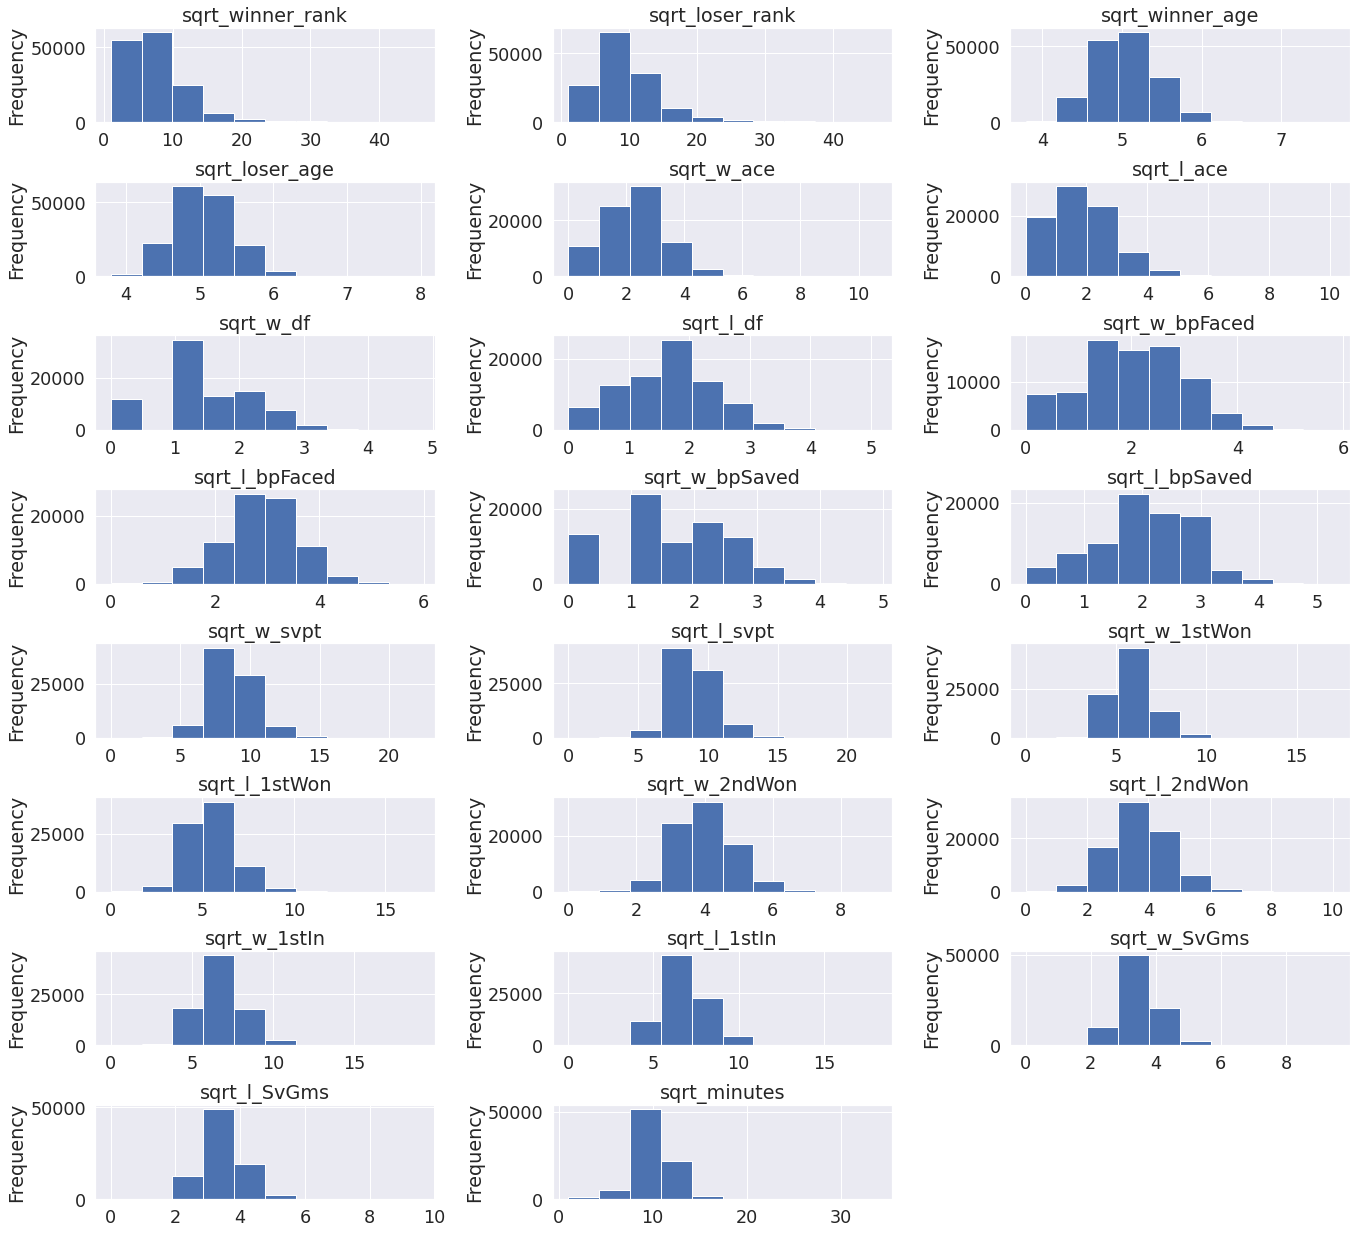

In [ ]:
#Checking if the data can be normalized
#Removing height since it appears normally distributed (though we will double check using normality tests in the section 'Player's Height')
hist_plots = [i for i in hist_plots if i not in ('winner_ht', 'loser_ht')]

for i in hist_plots:
  sqrt_name = 'sqrt_' + str(i)
  df[sqrt_name] = np.sqrt(df[i])

sqrt_hist_plots = [col for col in df.columns if 'sqrt_' in col]

plt.figure(1,figsize=(19,19))
for i in range(1,24):
    plt.subplot(9,3,i)
    df[sqrt_hist_plots[i-1]].plot(kind='hist',title=sqrt_hist_plots[i-1])
plt.tight_layout()

In [ ]:
# Check for skewness and kurtosis of transformed data
l = []
k = []
for i in sqrt_hist_plots:
 l.append(df[i].agg(['skew', 'kurtosis']))
 k.append(i)
pd.concat(l, keys=k).to_frame(name='')

sqrt_winner_rank skew      1.749372
                 kurtosis  5.600738
sqrt_loser_rank  skew      1.766241
                 kurtosis  5.156253
sqrt_winner_age  skew      0.308078
                 kurtosis  0.053696
sqrt_loser_age   skew      0.282803
                 kurtosis  0.165401
sqrt_w_ace       skew      0.143373
                 kurtosis  0.421611
sqrt_l_ace       skew      0.236478
                 kurtosis  0.387796
sqrt_w_df        skew     -0.172043
                 kurtosis -0.080057
sqrt_l_df        skew     -0.263141
                 kurtosis  0.374536
sqrt_w_bpFaced   skew     -0.238504
                 kurtosis -0.076726
sqrt_l_bpFaced   skew     -0.014444
                 kurtosis  0.617431
sqrt_w_bpSaved   skew     -0.199563
                 kurtosis -0.438116
sqrt_l_bpSaved   skew     -0.323465
                 kurtosis  0.404603
sqrt_w_svpt      skew      0.457811
                 kurtosis  0.677495
sqrt_l_svpt      skew      0.430135
                 kurtosis  1.018838
sqrt_w_1stWon    skew      0.528646
                 kurtosis  1.051753
sqrt_l_1stWon    skew      0.326367
                 kurtosis  0.706933
sqrt_w_2ndWon    skew      0.147020
                 kurtosis  0.529644
sqrt_l_2ndWon    skew      0.079846
                 kurtosis  0.378997
sqrt_w_1stIn     skew      0.469214
                 kurtosis  0.699950
sqrt_l_1stIn     skew      0.415879
                 kurtosis  0.827901
sqrt_w_SvGms     skew      0.501534
                 kurtosis  1.191090
sqrt_l_SvGms     skew      0.432804
                 kurtosis  1.474892
sqrt_minutes     skew     -0.282213
                 kurtosis  2.633291

- After transformation, majority of the data is still not normal so non-parameteric tests will be used in this analysis.

In [ ]:
#Dropping sqrt columns
df.drop(columns=sqrt_hist_plots, inplace=True)
df.shape

(169690, 49)

### **Drop irrelevant attributes:**
The attributes tourney_id, round, match_num, winner_id, loser_id, winner_entry, loser_entry, winner_name, loser_name, draw_size, score, and minutes are irrelevant for this analysis and will not be used.

We will drop winner_id, loser_id, and tourney_id since we have winner_name, loser_name, and tourney_name.

In [ ]:
df.drop(columns=['winner_id', 'loser_id', 'tourney_id'], inplace=True)

### **Creating new attributes:**

Create two new columns for the month of the tournament ('tourney_month') and the year the tournament took place ('tourney_year').


In [ ]:
#create a column that will store the tournament month
df['tourney_month'] = df['tourney_date'].dt.month

In [ ]:
#create a column that will store the tournament year
df['tourney_year'] = df['tourney_date'].dt.year

In [ ]:
#drop the column 'tourney_date'
df=df.drop(['tourney_date'], axis=1)

### **Dealing with missing values**

In [ ]:
#total number of missing values for each variable and their equivalent percentage
missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = round((df.isnull().sum()/df.isnull().count())*100,1).sort_values(ascending=False)
missing_df = pd.concat([missing, percent_missing], axis=1, keys = ["Total","% Missing"])
missing_df

Total  % Missing
draw_size           168458       99.3
winner_entry        154942       91.3
loser_entry         144351       85.1
loser_seed          136837       80.6
winner_seed         104395       61.5
minutes              87587       51.6
w_1stWon             86275       50.8
w_2ndWon             86275       50.8
l_bpFaced            86275       50.8
l_ace                86275       50.8
l_SvGms              86275       50.8
l_df                 86275       50.8
l_2ndWon             86275       50.8
l_1stWon             86275       50.8
w_1stIn              86275       50.8
l_svpt               86275       50.8
w_ace                86275       50.8
w_SvGms              86275       50.8
l_bpSaved            86275       50.8
w_bpFaced            86275       50.8
w_bpSaved            86275       50.8
w_df                 86275       50.8
w_svpt               86275       50.8
l_1stIn              86275       50.8
loser_rank_points    76665       45.2
winner_rank_points   75399       44.4
loser_ht             30638       18.1
loser_rank           23781       14.0
winner_rank          19917       11.7
winner_ht            18806       11.1
loser_age             4990        2.9
surface               2539        1.5
winner_age            1761        1.0
score                  176        0.1
loser_hand              85        0.1
winner_hand             39        0.0
tourney_year             0        0.0
loser_ioc                0        0.0
loser_name               0        0.0
match_num                0        0.0
round                    0        0.0
tourney_month            0        0.0
tourney_level            0        0.0
tourney_name             0        0.0
winner_ioc               0        0.0
winner_name              0        0.0
best_of                  0        0.0

Dropping columns that contain >85% of the data missing

In [ ]:
df.drop(columns=['draw_size','winner_entry','loser_entry'], inplace=True)

#### **1. Player's handedness**

There are 85 missing values for the variable 'loser_hand' and 39 missing values for the variable 'winner_hand'. We have labelled the missing hand data as unknown(U).

In [ ]:
#Filling missing hand data with unknown hand (U)
df['loser_hand'].fillna('U', inplace=True)
df['winner_hand'].fillna('U', inplace=True)

#### **2. Player's age**
There are 4,990 missing values for the variable 'loser_age' (approx. 2.9% of the total data) and 1761 missing values for the variable 'winner_age' (approx. 1% of the total data). Since the age of the winner and loser is not well correlated with any other variable in the dataset and since the 'winner_age' and 'loser_age' variables are skewed (see below) we have chosen to use the median value for replacing the missing values.

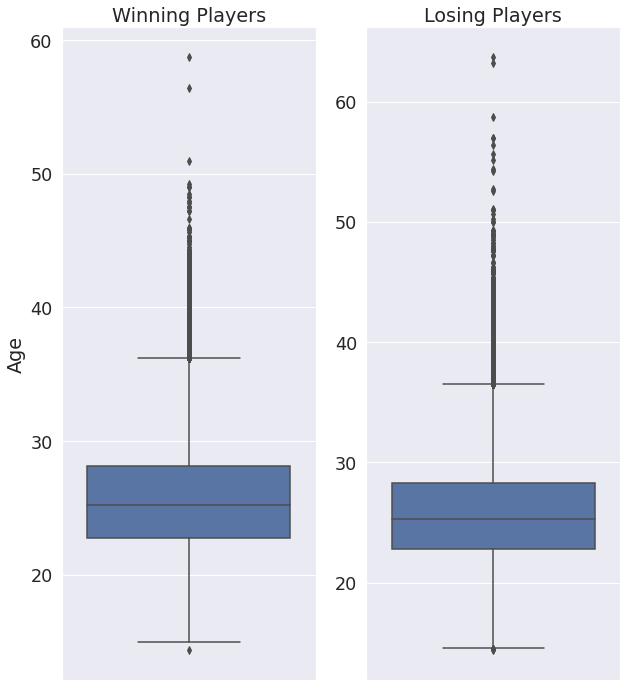

In [ ]:
fig,[ax1, ax2] = plt.subplots(1,2, figsize=(10,12)) #1 row, 2 columns
sns.boxplot(y='winner_age', ax=ax1, data=df).set_title("Winning Players")
sns.boxplot(y='loser_age', ax=ax2, data=df).set_title("Losing Players")
ax1.set_ylabel("Age")
ax2.yaxis.set_label_text("")
plt.show()

In [ ]:
#filling the missing values with the median
df['winner_age'] = df['winner_age'].fillna(df['winner_age'].median())
df['loser_age'] = df['loser_age'].fillna(df['loser_age'].median())

In [ ]:
print(df['winner_age'].isnull().sum()) #no more missing values
df['loser_age'].isnull().sum() #no more missing values

0


0

#### **3. Player's height**

There are 30,638 missing values for the variable 'loser_ht' (approx. 18.1% of the total data) and 18,806 missing values for the variable 'winner_ht' (approx. 11.1% of the total data). The histogram above shows a normal distribution, so the missing values were replaced with the mean in each category.

In [ ]:
# Check to make sure the total number of missing values has not changed
print(df['winner_ht'].isnull().sum())
print(df['loser_ht'].isnull().sum())

18806
30638


In [ ]:
# Filling the missing values with the mean
df['winner_ht'] = df['winner_ht'].fillna(df['winner_ht'].mean())
df['loser_ht'] = df['loser_ht'].fillna(df['loser_ht'].mean())

In [ ]:
# Check to make sure there are no more missing values
print(df['winner_ht'].isnull().sum())
print(df['loser_ht'].isnull().sum())

0
0


#### **4. Player's seed**
There are 136,837 missing values for the variable 'loser_seed' (approx. 80.6% of the total data) and 104,395 missing values for the variable 'winner_seed' (approx. 61.5% of the total data).

Players seed is based off the current ATP ranking of the player and is used to prevent top ranked players from facing each other early in a tournament. To impute this data we will use the respective median seed values per surface since each tournament can be further classified by the surface they are played on.

In [ ]:
df.groupby("surface")["winner_seed"].median()

surface
Carpet    4.0
Clay      5.0
Grass     6.0
Hard      5.0
None      NaN
Name: winner_seed, dtype: float64

In [ ]:
df.groupby("surface")["loser_seed"].median()

surface
Carpet    5.0
Clay      6.0
Grass     7.0
Hard      7.0
None      NaN
Name: loser_seed, dtype: float64

In [ ]:
#Imputing the missing seed data with the median seed per surface:
df['winner_seed'].fillna(df.groupby("surface")["winner_seed"].transform('median'), inplace=True)
df['loser_seed'].fillna(df.groupby("surface")["loser_seed"].transform('median'),inplace=True)
print(df['winner_seed'].isnull().values.any())
print(df['loser_seed'].isnull().values.any())

True
True


In [ ]:
#Dropping remaining null values:
df = df.dropna(subset=['winner_seed', 'loser_seed'])

#### **5. Dropping rows of data**

Most variables related to player match statistics have 51% of the data missing and since it is not possible to inpute the missing values we have decided to drop rows with missing values for the columns related to match statistcs (i.e. aces, df (double faults), svpt (serve percent), breakpoints, score, minutes, etc.).

In [ ]:
df = df.dropna(subset=['winner_rank_points','loser_rank_points','score','w_ace', #delete rows with missing data for game statistics
                       'l_ace','w_df','l_df','w_bpFaced','l_bpFaced','w_bpSaved',
                       'l_bpSaved','w_svpt','l_svpt','w_1stWon','l_1stWon',
                       'w_2ndWon','l_2ndWon','minutes'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80640 entries, 76907 to 169689
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   best_of             80640 non-null  int64  
 1   l_1stIn             80640 non-null  float64
 2   l_1stWon            80640 non-null  float64
 3   l_2ndWon            80640 non-null  float64
 4   l_SvGms             80640 non-null  float64
 5   l_ace               80640 non-null  float64
 6   l_bpFaced           80640 non-null  float64
 7   l_bpSaved           80640 non-null  float64
 8   l_df                80640 non-null  float64
 9   l_svpt              80640 non-null  float64
 10  loser_age           80640 non-null  float64
 11  loser_hand          80640 non-null  object 
 12  loser_ht            80640 non-null  float64
 13  loser_ioc           80640 non-null  object 
 14  loser_name          80640 non-null  object 
 15  loser_rank          80640 non-null  float64
 16 

In [ ]:
#Checking missing values
df.isnull().values.any()

False

In [ ]:
df.shape

(80640, 44)

# Player's Handedness (Left Hand vs Right Hand):

Determine if left-handed players have an advantage over right-handed players.

1. Do left-handed players win more matches against right-handed players
2. Where is left handedness advantageous?
 - Scoring more aces
 - Committing fewer double faults
 - Facing less breakpoints?
 - Saving more break points?
 - Is it in the serve?


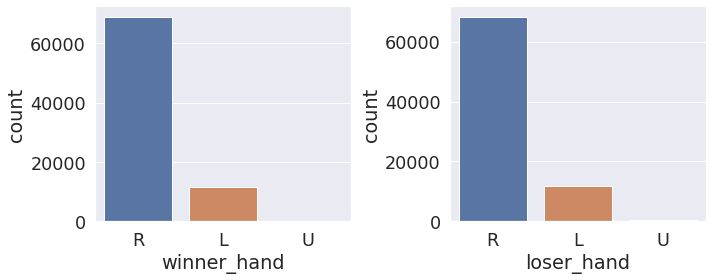

In [ ]:
#Initial look at cleaned hand data:
hand = df.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(ax=axes[0], x=hand['winner_hand'])
sns.countplot(ax=axes[1], x=hand['loser_hand'])
plt.tight_layout()
None

In [ ]:
right_hand = len(hand[(hand.winner_hand == 'R')]) + len(hand[(hand.loser_hand == 'R')])
left_hand = len(hand[(hand.winner_hand == 'L')]) + len(hand[(hand.loser_hand == 'L')])
unknown_hand = len(hand[(hand.winner_hand == 'U')]) + len(hand[(hand.loser_hand == 'U')])
total_hands = right_hand + left_hand + unknown_hand
print(f'The number of right-handed players {right_hand}, which is {round((right_hand/total_hands)*100,1)}% of the total players.')
print(f'The number of left-handed players {left_hand}, which is {round((left_hand/total_hands)*100,1)}% of the total players.')
print(f'The number of players where hand is unknown is {unknown_hand}, which is {round((unknown_hand/total_hands)*100,1)}% of the total players.')

The number of right-handed players 137334, which is 85.2% of the total players.
The number of left-handed players 23433, which is 14.5% of the total players.
The number of players where hand is unknown is 513, which is 0.3% of the total players.


- There are more right-handed players in the game than left-handed players.

### **1. Do left-handed players win more matches?**
**$H_0$:** There is no difference in the number of matches won by a left-handed player and a right-handed player.

**$H_A$:** Left-handed players win more matches against right-handed players.

Approach:
- Select only right vs left-handed matches
- Use a binomial test to determine if there is a statistical difference


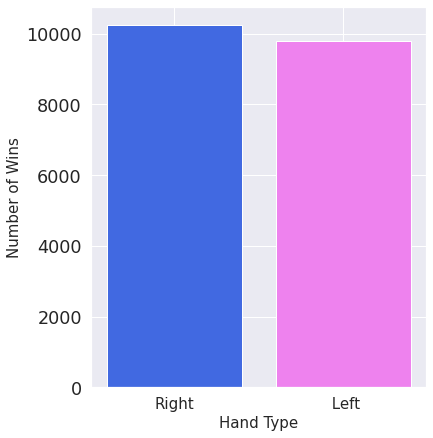

In [ ]:
#Select only right vs left handed matches
Right = len(hand[(hand.winner_hand == 'R') & (hand.loser_hand == 'L')])
Left = len(hand[(hand.winner_hand == 'L') & (hand.loser_hand == 'R')])
Total = Right+Left
hands = ['Right', ' Left']
wins = [Right, Left]
plt.figure(figsize=(6,7))
plt.bar(hands, wins, color=['royalblue','violet'], zorder=1.6)
plt.ylabel('Number of Wins', fontsize=15)
plt.xlabel('Hand Type', fontsize =15)
plt.grid(axis='y', zorder=0)
plt.xticks(fontsize=15)
None

- Bar graph shows that right-handed players win more matches so I will test two alternative hypothesis. One where left-handed players win more and the other that right-handed players win more.

In [ ]:
#Binomial Test to see if left handed or right handed players win more matches
pval = stats.binom_test(Left, n=Total, p=0.5, alternative='greater')
if pval < 0.05:
    print(f'Reject null hypothesis. Left-handed players won {round(100*(Left/Total),2)}% of the matches against right-handed players ({round(100*(Right/Total),2)}%)')
    print(f'Thus, left-handed players have the competitive advantage this difference is statistically significant ({pval} < 0.05)')
else:
  pval1 = stats.binom_test(Right, n=Total, p=0.5, alternative='greater')
  print(f'Fail to reject null hypothesis. Right-handed players won {round(100*(Right/Total),2)}% of the matches against left-handed players ({round(100*(Left/Total),2)}%)')
  print(f'Thus, right-handed players have the competitive advantage and this difference is statistically significant ({pval1} < 0.05)')

Fail to reject null hypothesis. Right-handed players won 51.11% of the matches against left-handed players (48.89%)
Thus, right-handed players have the competitive advantage and this difference is statistically significant (0.0008784064156022553 < 0.05)


### **2. Where is right handedness advantages during the match?**

To determine where during the match right handedness is more advantageous, I will look at the number of aces scored, double faults committed, breakpoints faced and saved, and the serve percentage of the players.
- Aces and serving are beneficial to players
- Double fault is an error committed by the player
- Breakpoint faced means that the player will lose the set if they fail to save the ball

Approach:
- Select matches between right and left handed players only.
-	Use a bar graph to see if the attributes indicate match success
- The non-parameteric, Mann-Whitney U test will be used for this analysis.
-	Plot the distribution per hand type for winners only. Required for the Mann-Whitney U test
- Use the Mann-Whitney U test to determine statistical significance





Mann-Whitney U test:

---

It compares whether the distribution of the dependent variable is the same for the two groups and therefore from the same population.

**Assumptions:**
1. All the observations from both groups are independent of each other,
2. The responses are at least ordinal (i.e., one can at least say, of any two observations, which is the greater),
3. Under the null hypothesis H0, the distributions of both populations are equal.
4. The alternative hypothesis H1 is that the distributions are not equal.

The following approach will be used to determine statistical difference:




#### Bar Plots

In [ ]:
#Select only right vs left handed matches
#Matches where the right handed players won
Right_stats = hand[(hand.winner_hand == 'R') & (hand.loser_hand == 'L')]
#Matches where the left handed players won
Left_stats = hand[(hand.winner_hand == 'L') & (hand.loser_hand == 'R')]

In [ ]:
def bar_subplots(df1, df2, win, lose, y_labels, titles):
    fig, axes = plt.subplots(3,2, figsize=(14,13))
    ax1 = 0
    ax2 = 0
    for i in range(len(win)):
        axes[ax1,ax2].bar('Right Wins', df1[str(win[i])].mean(),
                          color='royalblue', zorder=1.6)
        axes[ax1,ax2].bar('Left Wins', df2[str(win[i])].mean(),
                          color= 'violet', zorder=1.6)
        axes[ax1,ax2].bar('Right Loses', df2[str(lose[i])].mean(),
                          color= 'royalblue', zorder=1.6)
        axes[ax1,ax2].bar('Left Loses', df1[str(lose[i])].mean(),
                          color='violet', zorder=1.6)
        axes[ax1,ax2].set_xticks(['Right Wins', 'Left Wins', 'Right Loses',
                                  'Left Loses'])
        axes[ax1,ax2].set_ylabel(y_labels[i], fontsize=17)
        axes[ax1,ax2].set_title(titles[i], fontsize=17)
        if 1 <= i <3:
            ax1 = 1
        elif 3<= i < 4:
            ax1 = 2
        if ax2 == 0:
            ax2 = 1
        else:
            ax2 = 0
        if i == 4:
            fig.delaxes(axes[ax1,ax2])
    plt.tight_layout()

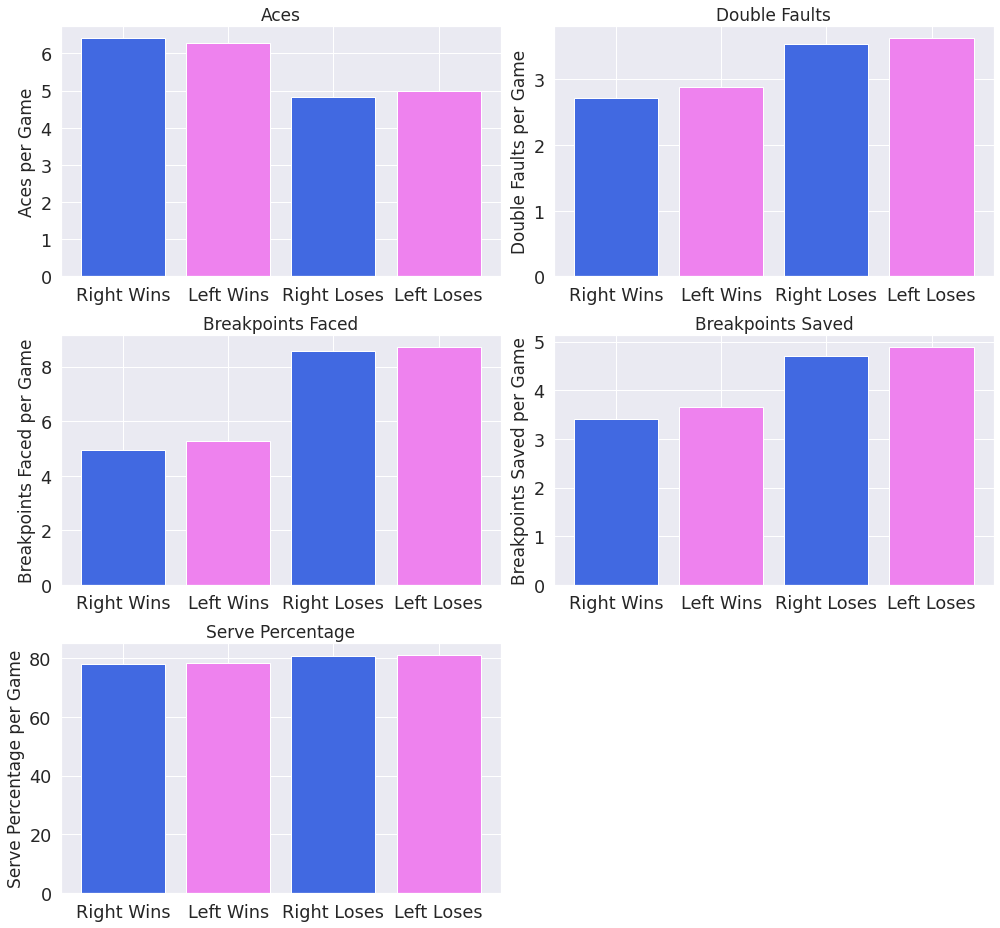

In [ ]:
win = ['w_ace','w_df','w_bpFaced','w_bpSaved','w_svpt']
lose = ['l_ace','l_df','l_bpFaced','l_bpSaved','l_svpt']
y_labels = ['Aces per Game', 'Double Faults per Game','Breakpoints Faced per Game',
           'Breakpoints Saved per Game', 'Serve Percentage per Game']
titles = ['Aces', 'Double Faults','Breakpoints Faced',
           'Breakpoints Saved', 'Serve Percentage']
bar_subplots(Right_stats, Left_stats, win, lose, y_labels, titles)

- Based on the averages, right-handed players score more aces, and commit fewer double faults.
- Regardless of winner or loser it seems that those who face more breakpoints also save more breakpoints. I will use a heatmap to see if there is a strong correlation between saving and facing.
- Losers have a higher serve percentage than winners suggesting that serving might not be a good measure of match success. A heatmap will be used to determine if there is a high correlation between winners and losers.

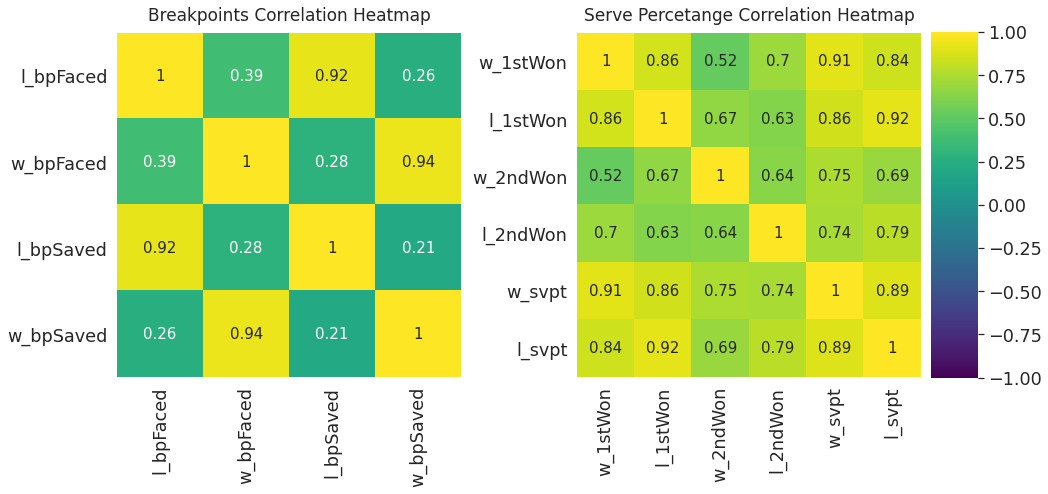

In [ ]:
# Check to see if there is a correlation between break points faced and saved
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,12))
heat1 = hand[['l_bpFaced','w_bpFaced','l_bpSaved','w_bpSaved']]
sns.heatmap(heat1.corr(), annot = True, square = True, cmap = "viridis", vmin = -1,
            vmax = 1, cbar_ax = fig.add_axes([.999, .3, .05, .4]),
            annot_kws = {'size':15}, ax=ax1)
ax1.set_title('Breakpoints Correlation Heatmap', fontdict={'fontsize':17}, pad=12)

# Check to see if there is a correlation between winner and loser serve percentage
heat2 = hand[['w_1stWon','l_1stWon','w_2ndWon','l_2ndWon','w_svpt','l_svpt']]
sns.heatmap(heat2.corr(), annot = True, square = True, cmap = "viridis", vmin = -1,
            vmax = 1, cbar_ax = fig.add_axes([.999, .3, .05, .4]),
            annot_kws = {'size':15}, ax=ax2)
ax2.set_title('Serve Percetange Correlation Heatmap', fontdict={'fontsize':17}, pad=12)
plt.tight_layout()
None

Breakpoints:
- There is a high correlation between the number of breakpoints a player faced and saved, regardless of whether they were a winner (94%) or a loser (92%).
- Finding the difference between breakpoints saved and breakpoints faced will determine which hand saves more breakpoints than faced. I will also check to see if this difference is highly correlated between winners and losers to determine if breakpoints are crucial to match success.

Serve Percentage:
- Winner and loser serve percentages are highly correlated (89%)
- Regardless of whether you have a high serve percentage, first serve percentage, or second serve percentage they all are highly correlated with winning and losing. Thus, serve percentage isn't a good measure of player success and will not be analyzed.

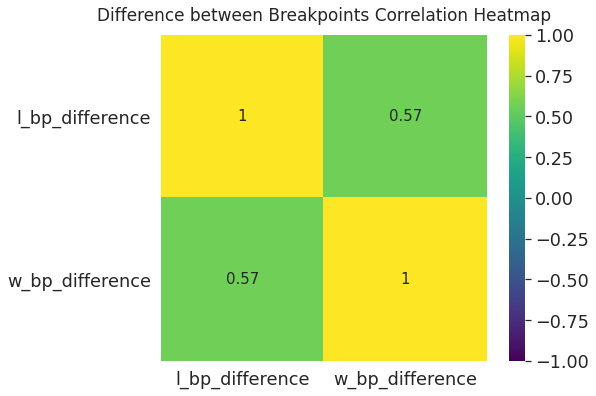

In [ ]:
# Find the difference in the break points (bpsaved - bpfaced)
# If difference > 0 then they save more points and the game continues
# If difference < 0 then they face more break points and will most likely lose the match

#Finding the difference per hand type:
Right_stats['w_bp_difference'] = Right_stats.w_bpSaved - Right_stats.w_bpFaced
Right_stats['l_bp_difference'] = Right_stats.l_bpSaved - Right_stats.l_bpFaced
Left_stats['w_bp_difference'] = Left_stats.w_bpSaved - Left_stats.w_bpFaced
Left_stats['l_bp_difference'] = Left_stats.l_bpSaved - Left_stats.l_bpFaced

#Finding the difference regardless of hand type:
df['w_bp_difference'] = df.w_bpSaved - df.w_bpFaced
df['l_bp_difference'] = df.l_bpSaved - df.l_bpFaced

#Seeing if there is a high correlation between winner and loser:
plt.figure(figsize=(8,6))
heat = df[['l_bp_difference','w_bp_difference']]
heatmap = sns.heatmap(heat.corr(), annot = True, square = True, cmap = "viridis",
            vmin = -1, vmax = 1, annot_kws = {'size':15})
heatmap.set_title('Difference between Breakpoints Correlation Heatmap',
                  fontdict={'fontsize':17}, pad=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=360)
None

- There is a slight correlation (57%) between winners and losers in the difference between breakpoints saved and faced. Thus, a player is more likely to win a game if this difference is small.

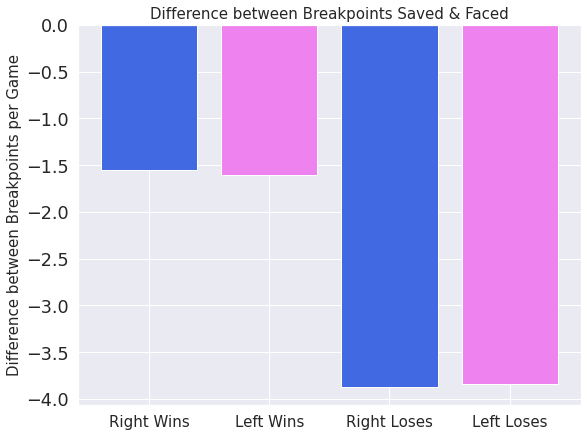

In [ ]:
#Plotting the average difference in break points saved vs faced between winners and losers:
plt.figure(figsize=(9,7))
plt.bar(1, Right_stats['w_bp_difference'].mean(), color='royalblue', zorder=1.6)
plt.bar(2, Left_stats['w_bp_difference'].mean(), color= 'violet', zorder=1.6)
plt.bar(3, Left_stats['l_bp_difference'].mean(), color= 'royalblue', zorder=1.6)
plt.bar(4, Right_stats['l_bp_difference'].mean(), color='violet', zorder=1.6)
plt.xticks([1,2,3,4], ['Right Wins', 'Left Wins', 'Right Loses', 'Left Loses'], fontsize=15)
plt.ylabel('Difference between Breakpoints per Game', fontsize=15)
plt.title('Difference between Breakpoints Saved & Faced', fontsize=15)
None

- The difference between break points saved & faced is the smallest (more positive) for right-handed winners.

#### Distribution Plots for Mann-Whitney U Test

In [ ]:
def distribution_subplots(df1, df2, match_stats, titles, legend, x_labels):
    fig, axes = plt.subplots(3, figsize=(13,10))
    for i in range(len(match_stats)):
        sns.distplot(df1[str(match_stats[i])], color='royalblue',
                     label=str(legend[0]), ax=axes[i],
                     hist_kws=dict(alpha=0.7))
        sns.distplot(df2[str(match_stats[i])], color= 'violet',
                     label=str(legend[1]),ax=axes[i],
                     hist_kws=dict(alpha=0.7))
        axes[i].set_title(titles[i],size=15)
        axes[i].set_xlabel(x_labels[i], fontsize=15)
        axes[i].set_ylabel('Frequency', fontsize=15)
        if i == (len(match_stats)-1) :
            axes[i].legend(loc='upper left', fontsize=13)
        else:
            axes[i].legend(loc='upper right', fontsize=13)
    plt.tight_layout()

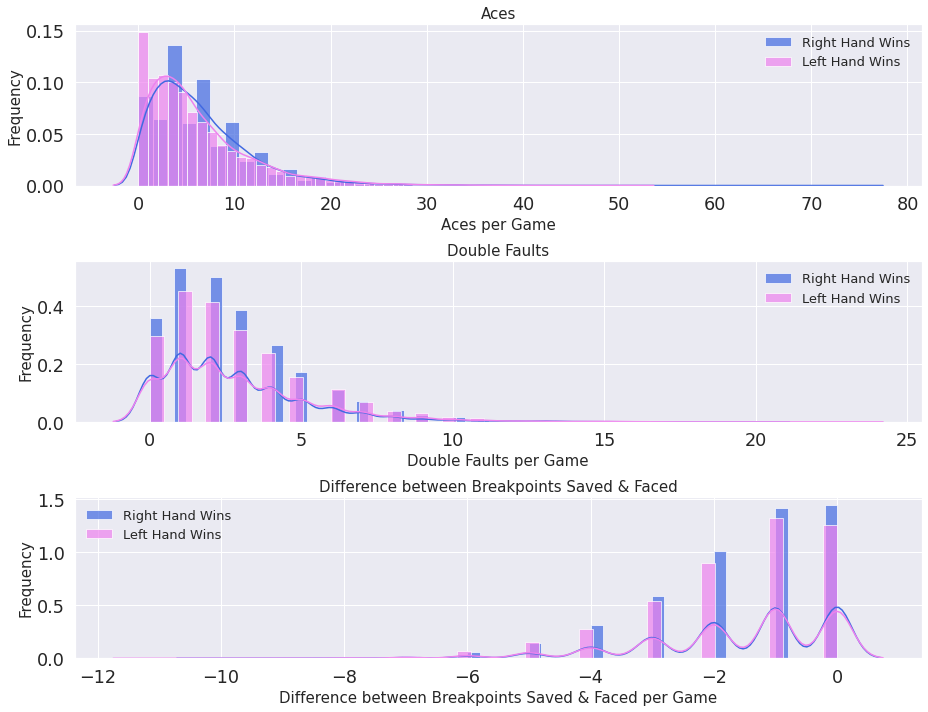

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference between Breakpoints Saved & Faced']
x_labels = ['Aces per Game', 'Double Faults per Game',
            'Difference between Breakpoints Saved & Faced per Game']
legend = ['Right Hand Wins','Left Hand Wins']
distribution_subplots(Right_stats, Left_stats, match_stats, titles, legend, x_labels)

#### Mann-Whitney U Test
**Hypotheses**

---


**$H_0$:** The distribution of the number of aces, double faults, and the difference in breakpoints saved vs faced per game by a right-handed player is the same as that of a left-handed player.

**Aces:**

**$H_A$:** The distribution of the number of aces scored per game by a right-handed player is greater than that of a left-handed player.

**Double Faults:**

**$H_A$:** The distribution of the number of double faults committed per game by a right-handed player is less than that of a left-handed player.

**Difference in Breakpoints:**

**$H_A$:** The distribution of the difference between breakpoints saved & faced per game by a right-handed player is greater than that of a left-handed player.

In [ ]:
def mann_whitney_u_test(df1, df2, match_stats, titles, median_names):
    l1 = []
    l2 = []
    U = []
    p = []
    outcome = []
    #Getting the median
    for i in range(len(match_stats)):
        l1.append(df1[str(match_stats[i])].median())
        l2.append(df2[str(match_stats[i])].median())
        #Mann-U Test:
        if titles[i].lower() == 'double faults':
            res = mannwhitneyu(df1[str(match_stats[i])], df2[str(match_stats[i])],
                               alternative="less")
            #Alernative is set to less because double fault is an error,
            #so I want to see if right handed players commit less double faults.

        else:
            res = mannwhitneyu(df1[str(match_stats[i])], df2[str(match_stats[i])],
                               alternative="greater")
        #Alternative is set to greater because we want to see if they scored more aces
        #For difference between breakpoints saved & faced the larger (more positive)
        #the difference, the more points they save than faced

        stat, pval = res
        U.append(stat)
        p.append(pval)
        if pval < 0.05:
            outcome.append('Reject null hypothesis')
        else:
            outcome.append('Fail to reject null hypothesis')

    results = pd.DataFrame(
        {'Title': titles,
         f'Median for {str(median_names[0])}': l1,
         f'Median for {str(median_names[1])}': l2,
         'Mann-Whitney U Statistic': U,
         'p-value': p,
         'Outcome': outcome,
        })
    return results

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference in Breakpoints Saved & Faced']
median_names = ['Right Hand', 'Left Hand']
mann_whitney_u_test(Right_stats, Left_stats, match_stats, titles, median_names)

Title  Median for Right Hand  \
0                                     Aces                    5.0   
1                            Double Faults                    2.0   
2  Difference in Breakpoints Saved & Faced                   -1.0   

   Median for Left Hand  Mann-Whitney U Statistic   p-value  \
0                   5.0                52144474.5  0.000001   
1                   2.0                48743291.0  0.000113   
2                  -1.0                50998113.5  0.027746   

                  Outcome  
0  Reject null hypothesis  
1  Reject null hypothesis  
2  Reject null hypothesis

- Overall, right-handed players scored more aces (p-value = 0.000001), committed fewer double faults (p-value = 0.000113), and had a more positive difference between breakpoints saved & faced (p-value=0.027746) than left-handed players in a win.


# Player's Age:

We wanted to determine how the age of a player might affect their performance in a tennis match. Would older players, likely with more experience playing at the top professional level, have an advantage over younger players that might not have reached their peak althetic performance and/or have less experience playing against the best tennis players in the world?

First, we looked at the distribution of both the age of players that won ('winner_age') and lost ('loser_age') each match.

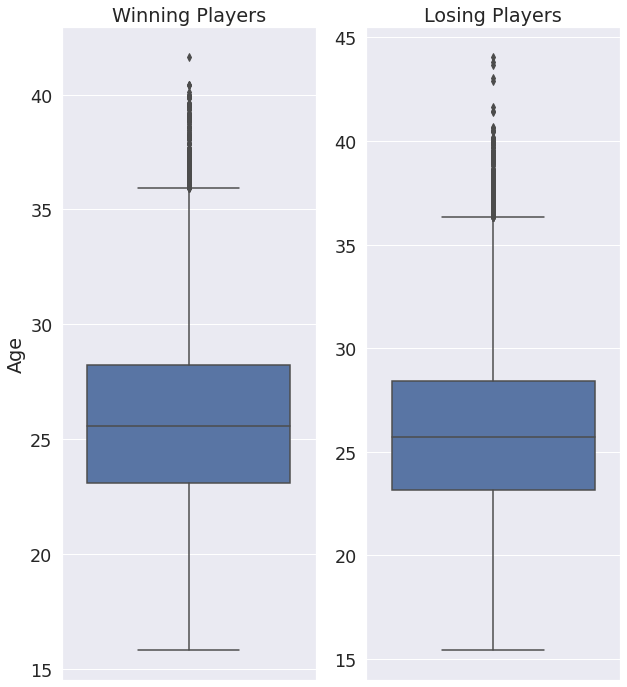

In [ ]:
fig,[ax1, ax2] = plt.subplots(1,2, figsize=(10,12)) #1 row, 2 columns
sns.boxplot(y='winner_age', ax=ax1, data=df).set_title("Winning Players")
sns.boxplot(y='loser_age', ax=ax2, data=df).set_title("Losing Players")
ax1.set_ylabel("Age")
ax2.yaxis.set_label_text("")
plt.show()

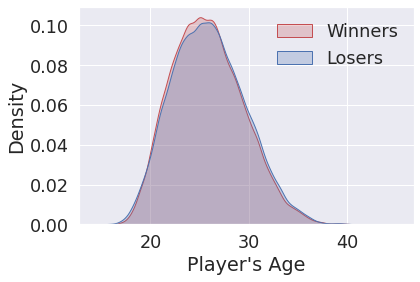

In [ ]:
fig = sns.kdeplot(df['winner_age'], shade=True, color="r", label="Winners")
fig = sns.kdeplot(df['loser_age'], shade=True, color="b", label="Losers")
plt.xlabel("Player's Age")

plt.legend()
plt.show()

Overall, we see that the distributions of the winning and losing player's ages are similarily positively skewed. Now, we will check to see if either variable is normally distributed and if not whether the data can be normnalized. First, using an Anderson-Darling test we check whether the variables have a normal distribution.

**$H_0$:** The sample comes from a normal distribution.

**$H_A$:** The sample is not coming from a normal distribution.


In [ ]:
#Anderson-Darling test for normality - null hypothesis is that the data comes
# from a normal distribution
columns=['winner_age', 'loser_age']

for i in columns:
    print([i])
    result = anderson(df[str(i)], dist='norm')
    for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, Data looks normal (Fail to reject H0)' % (sl, cv))
      else:
        print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))

['winner_age']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)
['loser_age']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)


The null hypothesis is rejected for both variables suggesting that all the variables are not normally distributed. In order to try and normalize the data we first wanted to identify the individual distribution of the variables using the lambda value estimated from the Box-Cox transformation.

In [ ]:
df['bc_winner_age'], lambda_value = stats.boxcox(df.winner_age)
lambda_value

-0.016417615802351793

In [ ]:
df['bc_loser_age'], lambda_value = stats.boxcox(df.loser_age)
lambda_value

0.15757975543121971

Since both lambda values are closest to the common logarithm transformation we will see if log transforming the data will help normalize the distributions.

In [ ]:
#log transform the age variables
df['winner_age_log'] = np.log(df['winner_age'])
df['loser_age_log'] = np.log(df['loser_age'])

In [ ]:
#Anderson-Darling test for normality
columns=['winner_age_log', 'loser_age_log']

for i in columns:
    print([i])
    result = anderson(df[str(i)], dist='norm')
    for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, Data looks normal (Fail to reject H0)' % (sl, cv))
      else:
        print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))

#delete the columns that were created and are no longer useful in the dataset
df=df.drop(['winner_age_log'], axis=1)
df=df.drop(['loser_age_log'], axis=1)
df=df.drop(['bc_winner_age'], axis=1)
df=df.drop(['bc_loser_age'], axis=1)

['winner_age_log']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)
['loser_age_log']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)


The null hypothesis that the log transformed samples are normally distributed is rejected for both variables. As such, we must only use statistical tests that do not assume normality.

A Wilcoxon signed rank test is a non-parametric paired difference test that was used to test whether the age of winners is greater than that of the losers. The reason we are using a paired test is because the variables 'winner_age' and 'loser_age' come from the same tennis match.

**$H_0$:** The median age of the winners is the same as that of the losers.

**$H_A$:** The median age of the winners is greater than that of the losers.

In [ ]:
#paired test - alternative set to greater to see if winners age is older than losers age
wilcoxon(df.winner_age, df.loser_age, alternative='greater')

WilcoxonResult(statistic=1572143572.5, pvalue=0.9999999999999959)

We can not reject the null hypothesis.

Now to look at an alternative approach and test whether the age of winners is less than that of the losers.

**$H_0$:** The median age of the winners is the same as that of the losers.

**$H_A$:** The median age of the winners is less than that of the losers.



In [ ]:
#paired test - alternative set to less to see if winners age is younger than losers age
wilcoxon(df.winner_age, df.loser_age, alternative='less')

WilcoxonResult(statistic=1572143572.5, pvalue=4.058647075126634e-15)

We can reject the null hypothesis. The median age of the winning players is less than the age of the losing players.

### **1. Age difference between players within the match**

In order to determine whether the winning player was older or younger than their opponent (i.e. losing player for their match) we created a new column 'age_difference' which is the difference between the winner's age ('winner_age') and the loser's age ('loser_age'). We then categorized the players into two age groups: older and younger (see section below). Older players had an 'age_difference' greater than zero (i.e. positive value) and younger players had an 'age_difference' less than zero (i.e. negtaive value).

In [ ]:
#create a column that is the age difference between the winner and loser
#positive value = winner is older and negative value = loser is older
df['age_difference'] = df['winner_age'] - df['loser_age']

In [ ]:
df.age_difference.describe()
#50% of the players competed against players that were within 3 years of their age

count    80640.000000
mean        -0.130925
std          4.946182
min        -25.920000
25%         -3.480000
50%         -0.150000
75%          3.190000
max         21.440000
Name: age_difference, dtype: float64

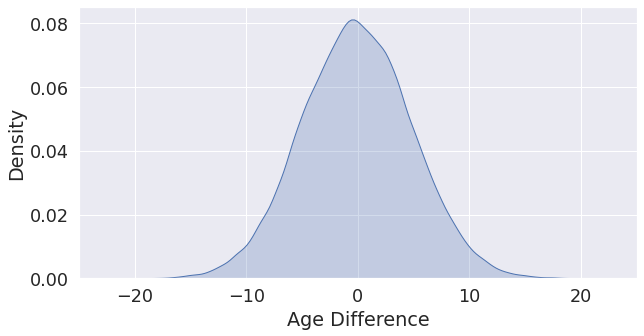

In [ ]:
plt.figure(figsize=(10,5))
plt.xlim(-25,25)
plt.xlabel('Age Difference')
plt.ylabel('Density')
sns.kdeplot(df['age_difference'],shade=True)
plt.show()

Observations:

Tennis matches were typically played between players of similar ages; 50% of the matches occurred between players that were within three years of each other. The largest age difference in a tennis match was roughly 26 years, with the losing player approximately 26 years older than the winning player of the match.

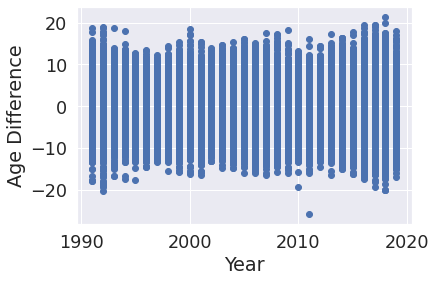

In [ ]:
plt.scatter(df.tourney_year,df.age_difference)
plt.ylabel("Age Difference")
plt.xlabel("Year");
#there is no strong relationship between the age of the winner and loser of a match and the tournament year
#i.e. winners haven't become progressively older or younger compared to their competitors over the years

## **2. Do older (possibly more experienced) players win more matches against younger players?**

**$H_0$:** There is no difference in the number of matches won by a younger player and an older player.

**$H_A$:** Older players win more matches against younger players.

Approach:
- Select only young vs older player matches
- Use a binomial test to determine if there is a statistical difference

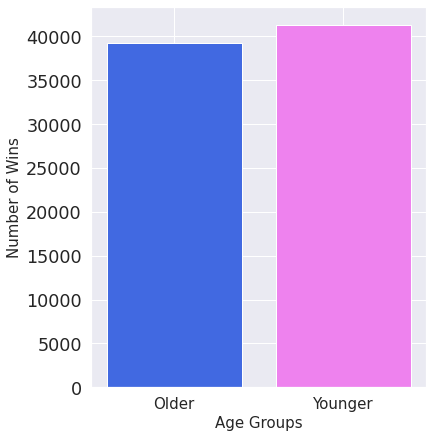

In [ ]:
older = len(df[df['age_difference']>0])
younger = len(df[df['age_difference']<0])
Total = older + younger
age = ['Older', 'Younger']
wins = [older, younger]
plt.figure(figsize=(6,7))
plt.bar(age, wins, color=['royalblue','violet'], zorder=1.6)
plt.ylabel('Number of Wins', fontsize=15)
plt.xlabel('Age Groups', fontsize =15)
plt.grid(axis='y', zorder=0)
plt.xticks(fontsize=15)
None

In [ ]:
#Binomial test to see if older or younger players win more matches
pval = stats.binom_test(older, n=Total, p=0.5, alternative='greater')
if pval < 0.05:
    print(f'Reject null hypothesis. Older players won {round(100*(older/Total),2)}% of the matches against younger players ({round(100*(younger/Total),2)}%)')
    print(f'Thus, older players have the competitive advantage this difference is statistically significant ({pval} < 0.05)')
else:
  pval1 = stats.binom_test(younger, n=Total, p=0.5, alternative='greater')
  print(f'Fail to reject null hypothesis. Younger players won {round(100*(younger/Total),2)}% of the matches against older players ({round(100*(older/Total),2)}%)')
  print(f'Thus, younger players have the competitive advantage and this difference is statistically significant ({pval1} < 0.05)')

Fail to reject null hypothesis. Younger players won 51.27% of the matches against older players (48.73%)
Thus, younger players have the competitive advantage and this difference is statistically significant (2.562163535669814e-13 < 0.05)


Using the binomial test we found that younger players won 51% of the matches against older players, and thus younger players have a significant (p-value =2.56x10-13) competitive advantage over older players. Next, we wanted to determine where during the match the younger players had an advantage.

In [ ]:
young = df[df['age_difference']<0]
print(young['winner_age'].median())
old = df[df['age_difference']>0]
print(old['winner_age'].median())

23.68
27.57


The median age of the older player that won a match against a younger opponent was around 28 years old and the median age of the younger player that won a match against an older opponent was around 24 years old.

## **3. Where do younger players have the advantage?**

Approach: Compare older winners who beat younger competitors to younger winners who beat older competitors and determine who scored more aces, comitted fewer double faults, and had a more positive difference between breakpoints faced and saved.

*Select matches between younger and older players only.

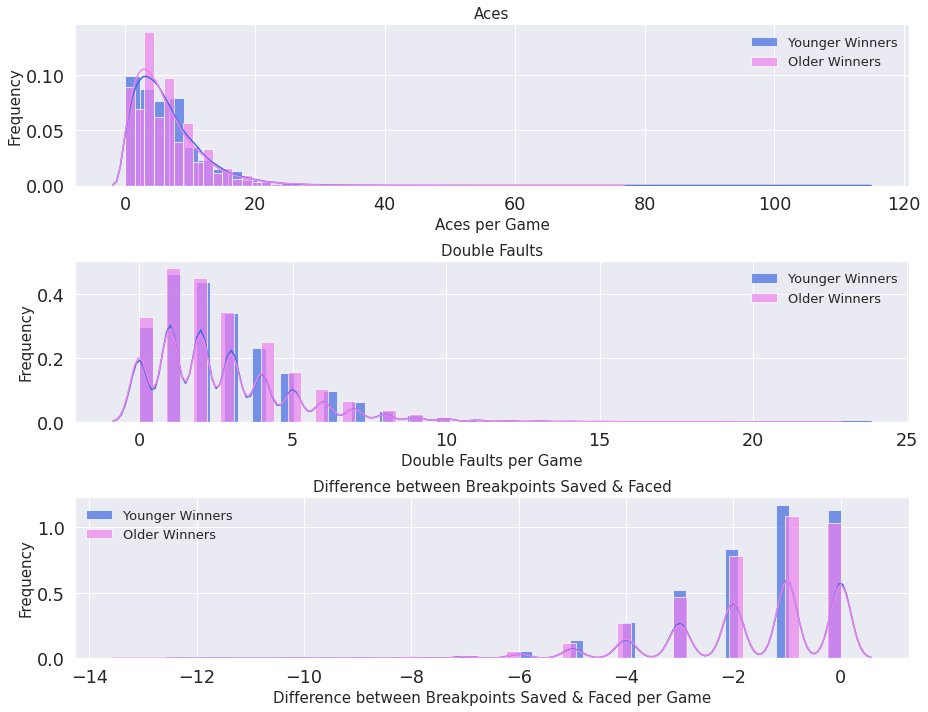

In [ ]:
#distribution plots for Mann-Whitney U test:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference between Breakpoints Saved & Faced']
x_labels = ['Aces per Game', 'Double Faults per Game',
            'Difference between Breakpoints Saved & Faced per Game']
legend = ['Younger Winners','Older Winners']
distribution_subplots(young, old, match_stats, titles, legend, x_labels)

Hypotheses for the Mann-Whitney U test:

**$H_0$:** The distribution of the number of aces, double faults, and the difference in breakpoints saved vs faced per game by a younger player is the same as that of an older player.

**Aces:**

**$H_A$:** The distribution of the number of aces scored per game by a younger player is greater than that of an older player.

**Double Faults:**

**$H_A$:** The distribution of the number of double faults committed per game by a younger player is less than that of an older player.

**Difference in Breakpoints:**

**$H_A$:** The distribution of the difference between breakpoints saved & faced per game by a younger player is greater than that of an older player.

In [ ]:
#Mann-Whitney U test:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference in Breakpoints Saved & Faced']
median_names = ['Younger Players', 'Older Players']
mann_whitney_u_test(young, old, match_stats, titles, median_names)

Title  Median for Younger Players  \
0                                     Aces                         5.0   
1                            Double Faults                         2.0   
2  Difference in Breakpoints Saved & Faced                        -1.0   

   Median for Older Players  Mann-Whitney U Statistic       p-value  \
0                       5.0               833514086.0  5.713109e-12   
1                       2.0               816160234.5  9.369270e-01   
2                      -1.0               813075241.0  2.773132e-01   

                          Outcome  
0          Reject null hypothesis  
1  Fail to reject null hypothesis  
2  Fail to reject null hypothesis

Overall, winners that were younger than their opponents scored more aces (p-value = 5.71e-12) but did not commit fewer double faults and did not have a more positive difference between breakpoints saved and faced.

### Scatter Plot Matrixes

We also looked at scatter plot matrixes of player's age against all player match attributes to see if there were any strong relationships/correlations. We found no obvious relationships.

#### Aces and Double Faults

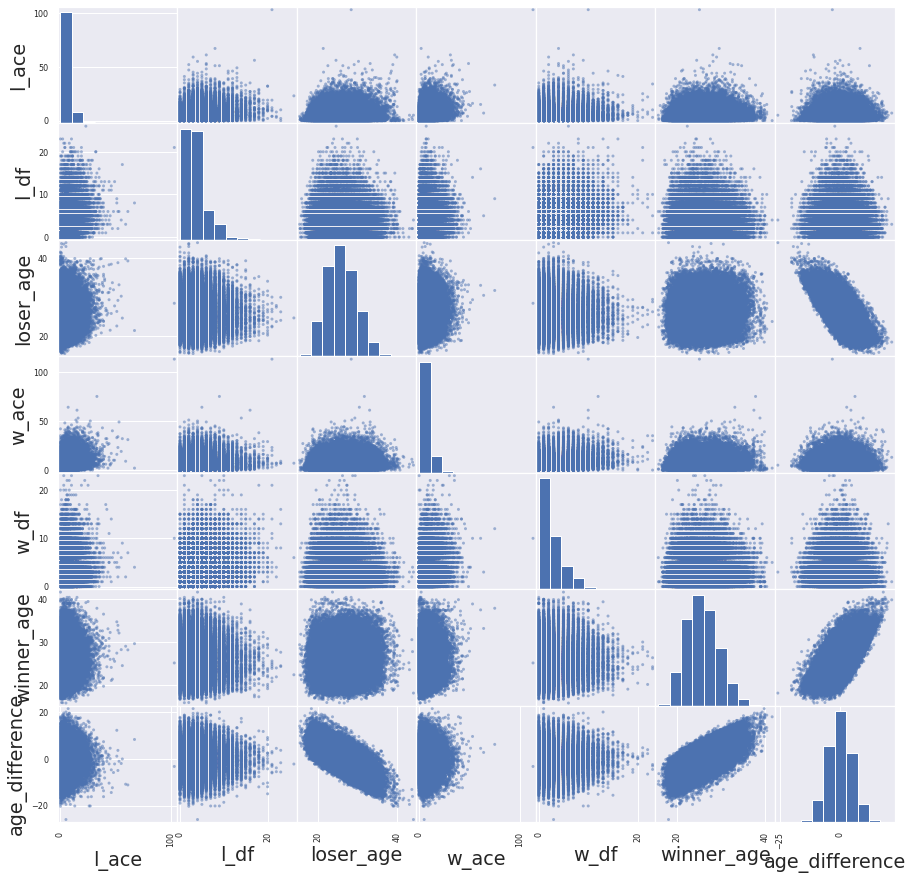

In [ ]:
#scatter plot matrix of player's age, aces, and double faults for both winners and losers
pd.plotting.scatter_matrix(df.iloc[:,[5,8,10,29,32,34,46]], figsize=(15,15))
plt.show();

#### Breakpoints Faced vs Breakpoints Saved

In [ ]:
#scatter plot matrix of player's age, breakpoints faced, and breakpoints saved for both winners and losers
pd.plotting.scatter_matrix(df.iloc[:,[6,7,10,30,31,34,46]], figsize=(15,15))
plt.show();

# Player's Height:

We wanted to determine how the height of a player might affect their performance in a tennis match. Would taller players have an advantage over shorter players?

First, we looked at the distribution of both the height of players that won ('winner_ht') and lost ('loser_ht') each match.

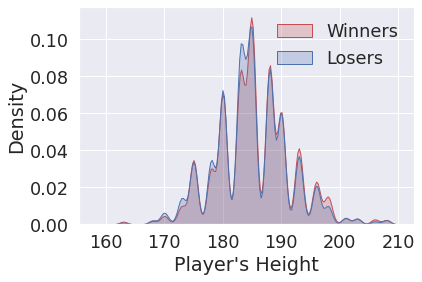

In [ ]:
fig = sns.kdeplot(df['winner_ht'], shade=True, color="r", label="Winners")
fig = sns.kdeplot(df['loser_ht'], shade=True, color="b", label="Losers")
plt.xlabel("Player's Height")

plt.legend()
plt.show()

To test that the winning and losing player's height for each match are normally distributed, we performed a Shapiro-Wilk test for normality.

In [ ]:
#Shapiro-Wilk test for normality:
columns=['winner_ht', 'loser_ht']
alpha=0.05

for i in columns:
    print([i])
    a,b=shapiro(df[[i]])
    print("Statistics", a, "p-value", b)
    if b < alpha:
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

['winner_ht']
Statistics 0.9771471619606018 p-value 0.0
The null hypothesis can be rejected
['loser_ht']
Statistics 0.9766011238098145 p-value 0.0
The null hypothesis can be rejected


The Shapiro-Wilk test for normality found that the null hypothesis (i.e. samples come from a normal distribution) can be rejected for the variables 'winner_ht' and 'loser_ht', thus determining that these two variables are not normally distributed. We also performed an Anderson-Darling test for normality just to be sure since the variables visually appear normally distributed.

In [ ]:
#Anderson-Darling test for normality
columns=['winner_ht', 'loser_ht']

for i in columns:
    print([i])
    result = anderson(df[str(i)], dist='norm')
    for i in range(len(result.critical_values)):
      sl, cv = result.significance_level[i], result.critical_values[i]
      if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, Data looks normal (Fail to reject H0)' % (sl, cv))
      else:
        print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))

['winner_ht']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)
['loser_ht']
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)


The Anderson-Darling normality test confirms that the data for 'winner_ht' and 'loser_ht' in the cleaned dataset are not normally distributed.

Similar to the age analysis above, we will use a Wilcoxon signed rank test (i.e. a non-parametric paired difference test) to determine whether the height of winners is greater than that of the losers. The reason we are using a paired test is because the variables 'winner_ht' and 'loser_ht' come from the same tennis match.

𝐻0 : The median height of the winners is the same as that of the losers.

𝐻𝐴 : The median height of the winners is greater than that of the losers

In [ ]:
#paired test - alternative set to greater to see if winners height is greater than losers height
wilcoxon(df.winner_ht, df.loser_ht, alternative='greater')

WilcoxonResult(statistic=1388059960.0, pvalue=9.997683973468872e-50)

We can reject the null hypothesis. The median height of the winning players is greater than the median height of the losing players.

### **1. Height difference between players within the match**

Similar to the attribute "age",  we wanted to determine whether the winning player was taller or shorter than their opponent and thus created a new column 'ht_difference' which is the difference between the winner's height ('winner_ht') and the loser's height ('loser_ht'). We then categorized the players into two height groups: taller and shorter (see section below). Taller players had an 'ht_difference' greater than zero (i.e. positive value) and shorter players had an 'ht_difference' less than zero (i.e. negtaive value).

In [ ]:
df['ht_difference'] = df['winner_ht'] - df['loser_ht']
df.ht_difference.describe()

count    80640.000000
mean         0.496923
std          9.027279
min        -45.000000
25%         -5.000000
50%          0.000000
75%          5.935082
max         43.000000
Name: ht_difference, dtype: float64

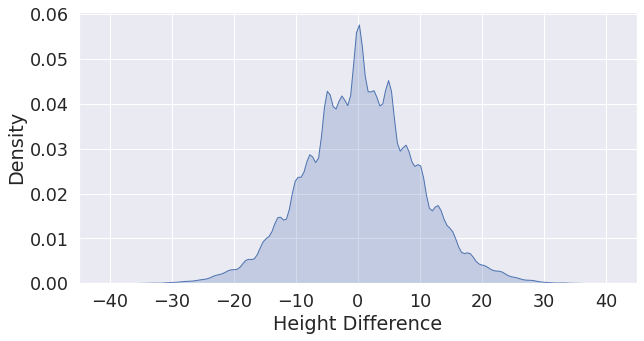

In [ ]:
plt.figure(figsize=(10,5))
plt.xlim(-45,45)
plt.xlabel('Height Difference')
plt.ylabel('Density')
sns.kdeplot(df['ht_difference'],shade=True)
plt.show()

Observations:

Tennis matches were typically played between players of relatively similar heights; 50% of the matches occurred between players that were within 5 to 6 cm in height of each other. The largest height difference in a tennis match was 45 cm, with the losing player approximately 45 cm taller than the winning player of the match.

## **2. Do taller palyers win more matches?**

**$H_0$:** There is no difference in the number of matches won by a shorter player and a taller player.

**$H_A$:** Taller players win more matches against shorter players.

Approach:
- Select only shorter vs taller player matches
- Use a binomial test to determine if there is a statistical difference

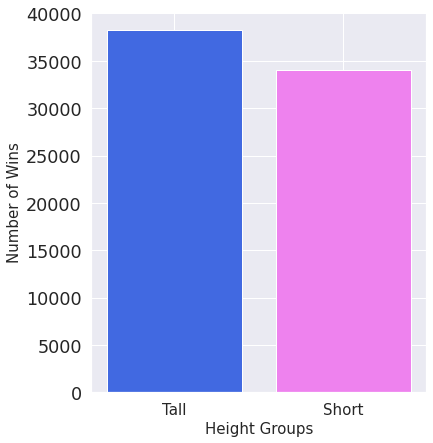

In [ ]:
taller = len(df[df['ht_difference']>0])
shorter = len(df[df['ht_difference']<0])
Total = taller + shorter
ht = ['Tall', 'Short']
wins = [taller, shorter]
plt.figure(figsize=(6,7))
plt.bar(ht, wins, color=['royalblue','violet'], zorder=1.6)
plt.ylabel('Number of Wins', fontsize=15)
plt.xlabel('Height Groups', fontsize =15)
plt.grid(axis='y', zorder=0)
plt.xticks(fontsize=15)
None

In [ ]:
#Binomial Test to see if taller or shorter players win more matches
pval = stats.binom_test(taller, n=Total, p=0.5, alternative='greater')
if pval < 0.05:
    print(f'Reject null hypothesis. Taller players won {round(100*(taller/Total),2)}% of the matches against shorter players ({round(100*(shorter/Total),2)}%)')
    print(f'Thus, taller players have the competitive advantage this difference is statistically significant ({pval} < 0.05)')
else:
  pval1 = stats.binom_test(shorter, n=Total, p=0.5, alternative='greater')
  print(f'Fail to reject null hypothesis. Shorter players won {round(100*(shorter/Total),2)}% of the matches against taller players ({round(100*(taller/Total),2)}%)')
  print(f'Thus, shorter players have the competitive advantage and this difference is statistically significant ({pval1} < 0.05)')

Reject null hypothesis. Taller players won 52.95% of the matches against shorter players (47.05%)
Thus, taller players have the competitive advantage this difference is statistically significant (3.9737387957919345e-57 < 0.05)


Using the binomial test we found that taller players won 53% of the matches against shorter players, and thus taller players have a significant (p-value =3.97e-57) competitive advantage over shorter players. Next, we wanted to determine where during the match the taller players had an advantage.

In [ ]:
tall = df[df['ht_difference']>0]
print(tall['winner_ht'].mean())
short = df[df['ht_difference']<0]
print(short['winner_ht'].mean())

189.16673294904655
181.25723124396717


The median height of the taller player that won a match against a shorter opponent was around 189 cm and the median height of the shorter player that won a match against a taller opponent was around 181 cm.

## **3. Where do taller players have the advantage?**

Approach: Compare taller winners who beat shorter competitors to shorter winners who beat taller competitors and determine who scored more aces, comitted fewer double faults, and had a more positive difference between breakpoints faced and saved.

*Select matches between shorter and taller players only.

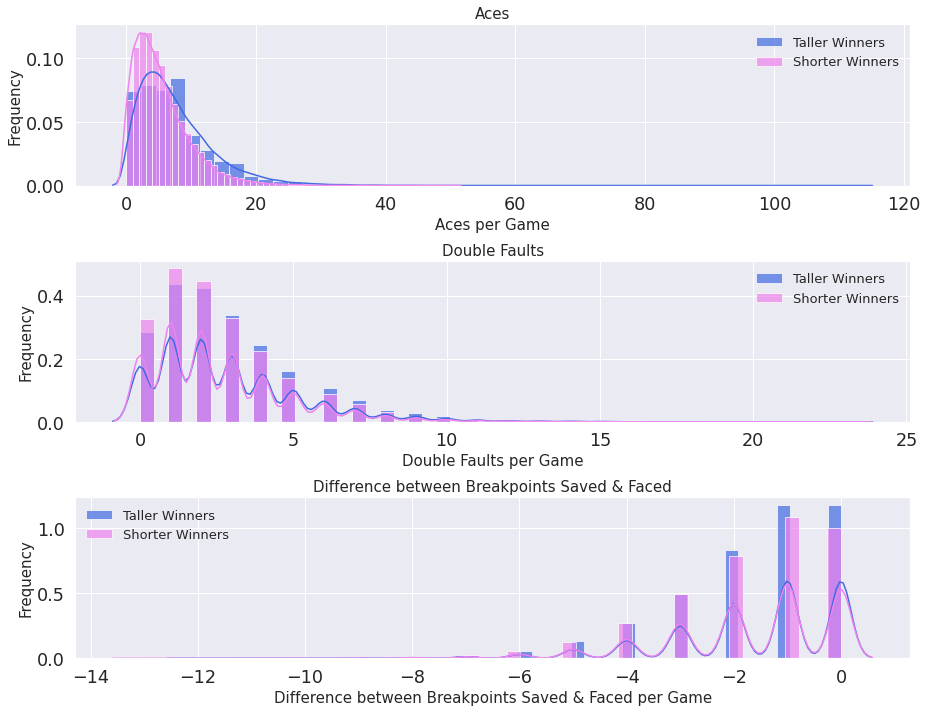

In [ ]:
#distribution plots for Mann-Whitney U test:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference between Breakpoints Saved & Faced']
x_labels = ['Aces per Game', 'Double Faults per Game',
            'Difference between Breakpoints Saved & Faced per Game']
legend = ['Taller Winners','Shorter Winners']
distribution_subplots(tall, short, match_stats, titles, legend, x_labels)

Hypotheses for the Mann-Whitney U test:

**$H_0$:** The distribution of the number of aces, double faults, and the difference in breakpoints saved vs faced per game by a taller player is the same as that of a shorter player.

**Aces:**

**$H_A$:** The distribution of the number of aces scored per game by a taller player is greater than that of a shorter player.

**Double Faults:**

**$H_A$:** The distribution of the number of double faults committed per game by a taller player is less than that of a shorter player.

**Difference in Breakpoints:**

**$H_A$:** The distribution of the difference between breakpoints saved & faced per game by a taller player is greater than that of a shorter player.

In [ ]:
#Mann-Whitney U test:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference in Breakpoints Saved & Faced']
median_names = ['Taller Players', 'Shorter Players']
mann_whitney_u_test(tall, short, match_stats, titles, median_names)

Title  Median for Taller Players  \
0                                     Aces                        6.0   
1                            Double Faults                        2.0   
2  Difference in Breakpoints Saved & Faced                       -1.0   

   Median for Shorter Players  Mann-Whitney U Statistic       p-value  \
0                         4.0               816276255.5  0.000000e+00   
1                         2.0               694415715.0  1.000000e+00   
2                        -1.0               670689409.5  4.411716e-14   

                          Outcome  
0          Reject null hypothesis  
1  Fail to reject null hypothesis  
2          Reject null hypothesis

Overall, winners that were taller than their opponents scored more aces (p-value = 0.00) and had a more positive difference between breakpoints saved and faced (p-value = 4.41e-14) but did not commit fewer double faults.

### Scatter Plot Matrixes

We also looked at scatter plot matrixes of player's height against all player match attributes to see if there were any strong relationships/correlations.

#### Aces vs Double Faults

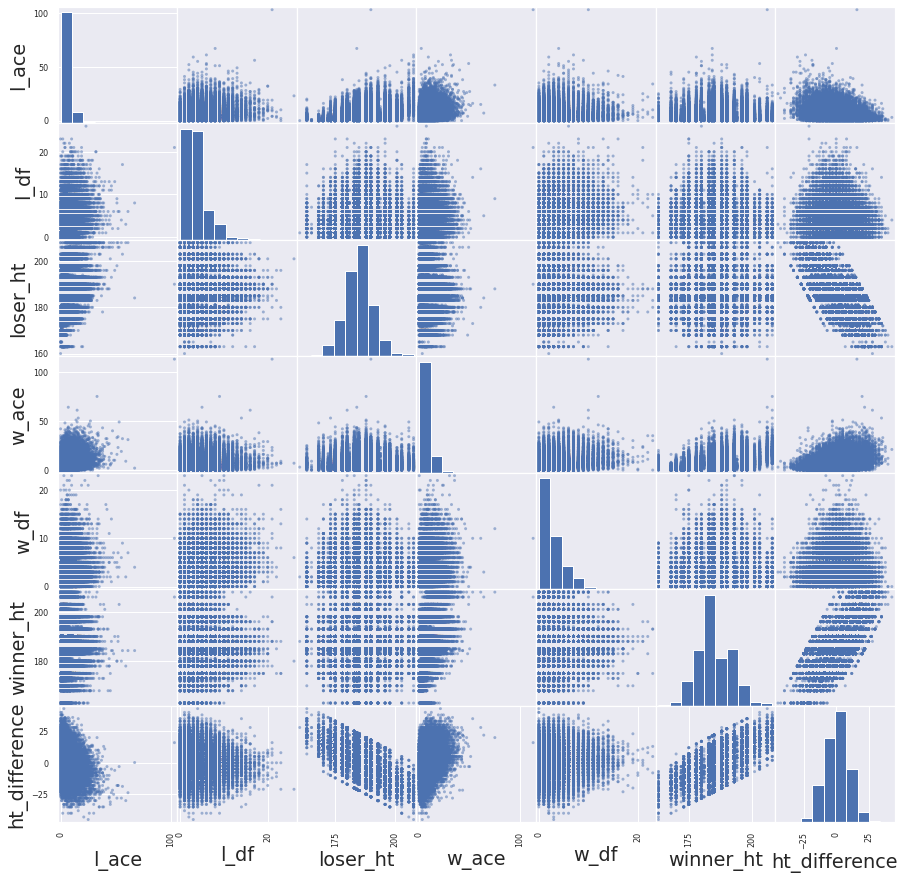

In [ ]:
#scatter plot matrix of player's height, aces, and double faults for both winners and losers
pd.plotting.scatter_matrix(df.iloc[:,[5,8,12,29,32,36,47]],figsize=(15,15))
plt.show();

Observations:
The height of the losing player has a moderate positive correlation with the number of aces scored by the loser (i.e. the taller the losing player the more aces scored). The height of the winning player has a moderate positive correlation with the number of aces scored by the winner (i.e. a trend towards the taller the winning player the more aces scored). There also appears to be a unimodal distribution between the height of the winning and losing player and the number of double faults they committed (i.e. winning and losing players of average height committed more double faults).

#### Breakpoints Faced vs Breakpoints Saved

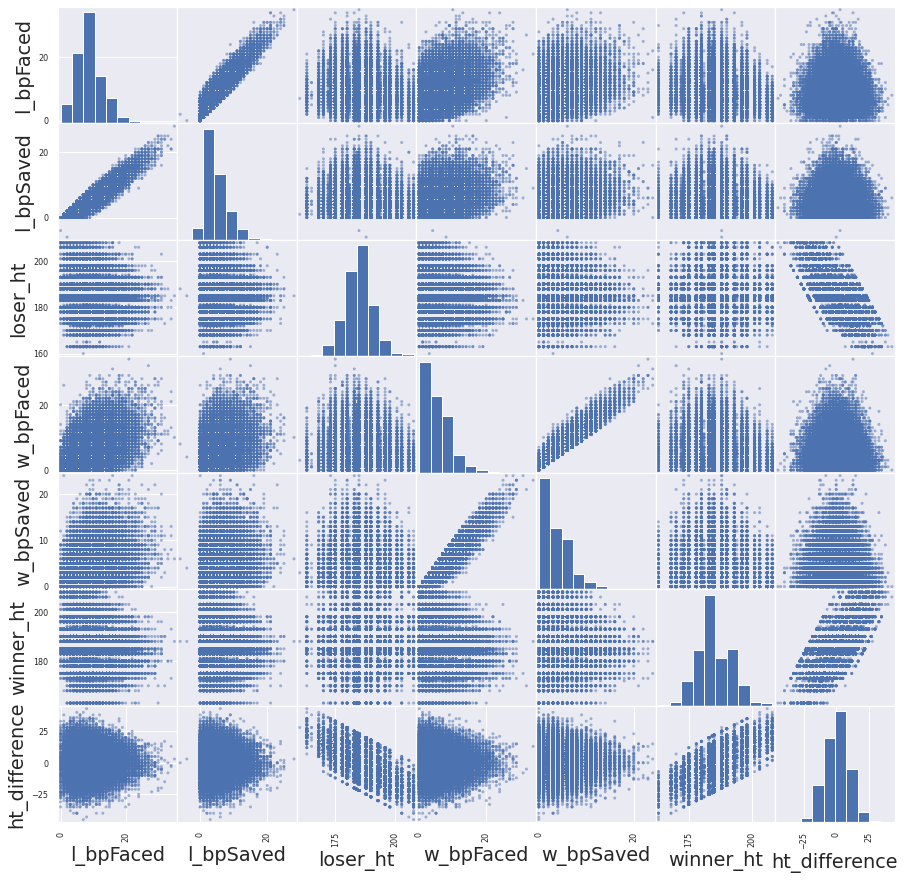

In [ ]:
#scatter plot matrix of player's height, breakpoints faced, and saved for both winners and losers
pd.plotting.scatter_matrix(df.iloc[:,[6,7,12,30,31,36,47]],figsize=(15,15))
plt.show();

Observations:
There appears to be a unimodal distribution between the height of the winning and losing player and their respective breakpoints faced and saved (i.e. winning and losing players of average height appear to have a greater number of breakpoints saved and faced than players that were on the taller or shorter end of the height spectrum).

# Tournament Surface:


### **1. Surface and Player's Handedness**

* Determine if left-handed players have an advantage over right-handed players on any particular surface
* Scoring more aces
* Committing fewer double faults
* Facing less breakpoints?
* Saving more break points?




In [ ]:
df.surface.unique()

array(['Hard', 'Carpet', 'Clay', 'Grass'], dtype=object)

In [ ]:
#replace 'Unknown' winner hand with NaN
df_sf = df.copy()
df_sf['winner_hand'].replace('U',np.NaN,inplace=True)
df2=df_sf[['surface','winner_hand','loser_hand']]
df_diff=df2[df2.winner_hand!=df2.loser_hand]
df_diff

surface winner_hand loser_hand
76904     Hard           R          L
76903     Hard           R          L
76900     Hard           R          L
76898     Hard           L          R
76912     Hard           L          R
...        ...         ...        ...
169633    Hard           L          R
169629    Hard           R          L
169626    Hard           L          R
169624    Hard           R          L
169689    Clay           L          R

[20551 rows x 3 columns]

In [ ]:
df_diff.isnull().sum()

surface          0
winner_hand    151
loser_hand       0
dtype: int64

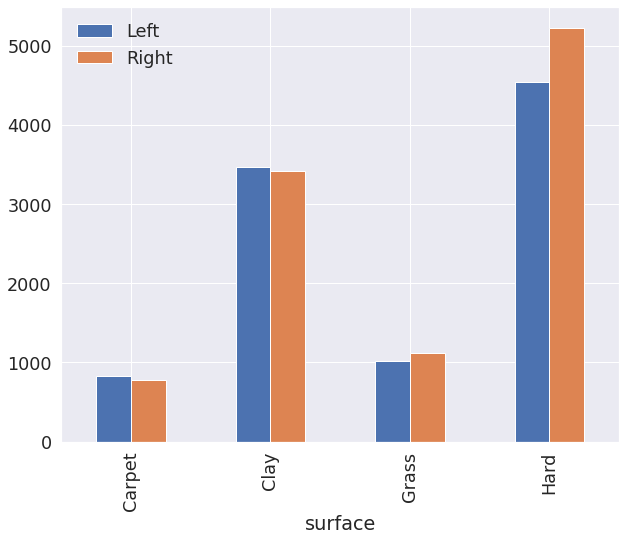

In [ ]:
df_plot = df_diff.groupby(['winner_hand', 'surface']).size().reset_index().pivot(columns='winner_hand', index='surface', values=0)
df_plot.plot(kind='bar', stacked=False,figsize=(10, 8))
L=plt.legend()
L.get_texts()[0].set_text('Left')
L.get_texts()[1].set_text('Right')

In [ ]:
def calculate_winning_percent(df):
    right_winners=len(df[df.winner_hand=='R'])
    left_winners=len(df[df.winner_hand=='L'])
    Total=len(df)
    print(f'The left handed player has a {round(100*(left_winners/Total),2)}% chance of winning against a right handed player on {df.surface.iloc[0]} surface')

In [ ]:
Hard = df_diff[df_diff.surface == 'Hard']
Carpet = df_diff[df_diff.surface == 'Carpet']
Clay = df_diff[df_diff.surface == 'Clay']
Grass = df_diff[df_diff.surface == 'Grass']
surfaces=[Hard,Carpet,Clay,Grass]
for sf in surfaces:
    calculate_winning_percent(sf)

The left handed player has a 46.09% chance of winning against a right handed player on Hard surface
The left handed player has a 51.59% chance of winning against a right handed player on Carpet surface
The left handed player has a 49.91% chance of winning against a right handed player on Clay surface
The left handed player has a 47.42% chance of winning against a right handed player on Grass surface


Observations:
1. Left handed players are more likely to win on carpet and clay surfaces
2. Right handed players are more likely to win on grass and hard surfaces

H0: There is no relationship between playing surface and player hand

HA: There is a relationship between surface and player hand

In [ ]:
#Creating the contingency table to apply Chi-Squared test
data_crosstab = pd.crosstab(index=df_diff['surface'],
                            columns=df_diff['winner_hand'],
                                margins = False)
print(data_crosstab)

winner_hand     L     R
surface                
Carpet        825   773
Clay         3466  3420
Grass        1021  1122
Hard         4542  5231


In [ ]:
stat, p, dof, expected_values = chi2_contingency(data_crosstab)

In [ ]:
observed_values=data_crosstab.values
observed_values

array([[ 825,  773],
       [3466, 3420],
       [1021, 1122],
       [4542, 5231]])

In [ ]:
expected_values

array([[ 771.89666667,  826.10333333],
       [3326.20803922, 3559.79196078],
       [1035.15303922, 1107.84696078],
       [4720.7422549 , 5052.2577451 ]])

In [ ]:
alpha = 0.05
chi_square=sum([(o-e)**2./e for o,e in zip(observed_values,expected_values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:",chi_square_statistic)

chi-square statistic: 31.897279214466227


In [ ]:
critical_value=chi2.ppf(q=1-alpha,df=dof)
print('critical_value:',critical_value)

critical_value: 7.814727903251179


In [ ]:
#p-value
p_value=1-(chi2.cdf(x=chi_square_statistic,df=dof))
print('p-value:',p_value)

p-value: 5.500939688207751e-07


In [ ]:
print('Significance level: ',alpha)
print('Degree of Freedom: ',dof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)

Significance level:  0.05
Degree of Freedom:  3
chi-square statistic: 31.897279214466227
critical_value: 7.814727903251179
p-value: 5.500939688207751e-07


In [ ]:
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between surface and winner hand")
else:
    print("Retain H0,There is no relationship between surface and winner hand")

if p_value<=alpha:
    print("Reject H0,There is a relationship between surface and winner hand")
else:
    print("Retain H0,There is no relationship between surface and winner hand")

Reject H0,There is a relationship between surface and winner hand
Reject H0,There is a relationship between surface and winner hand


### **2. Aces vs Double Faults and Breakpoints Faced vs Breakpoints Saved**

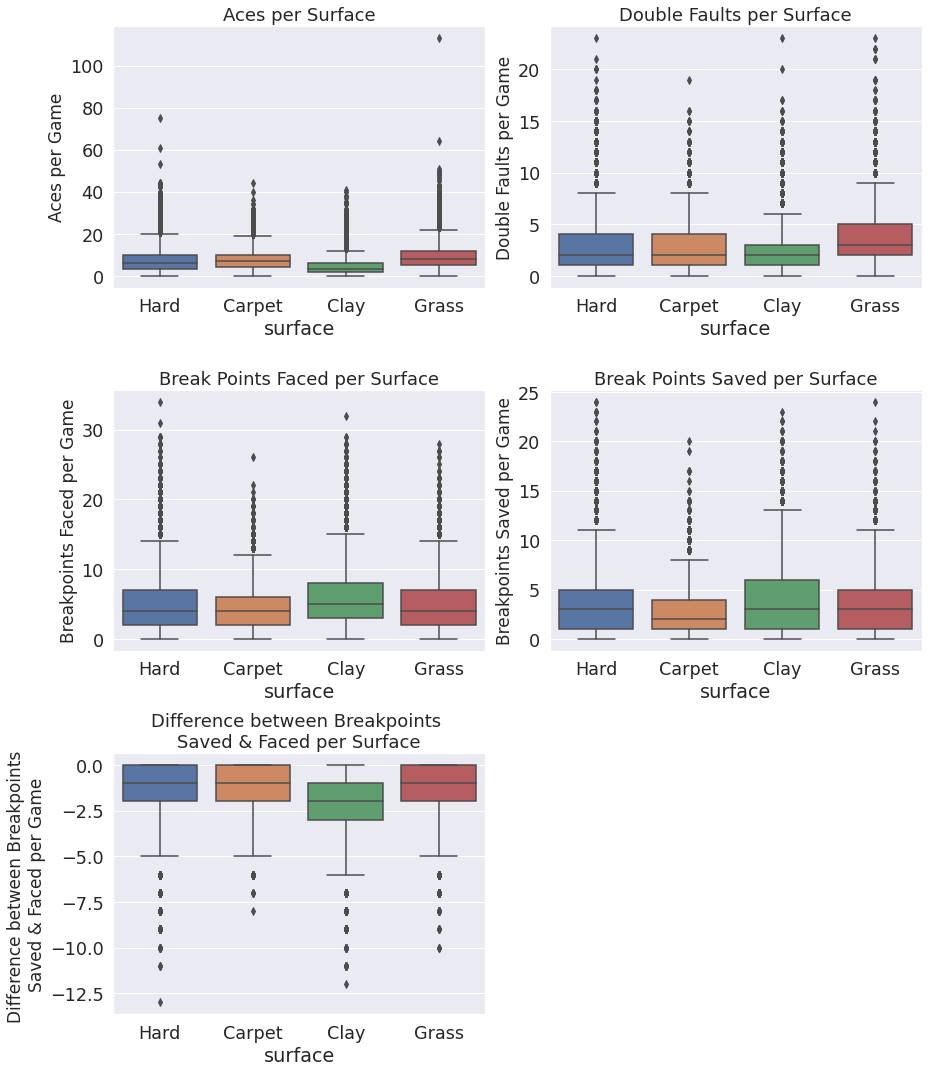

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(13, 15))

sns.boxplot(ax=axes[0, 0], data=df, x='surface', y='w_ace')
axes[0, 0].set_ylabel('Aces per Game', size=17)
axes[0, 0].set_title('Aces per Surface', size=18)
sns.boxplot(ax=axes[0, 1], data=df, x='surface', y='w_df')
axes[0, 1].set_ylabel('Double Faults per Game', size=17)
axes[0, 1].set_title('Double Faults per Surface', size=18)
sns.boxplot(ax=axes[1, 0], data=df, x='surface', y='w_bpFaced')
axes[1, 0].set_ylabel('Breakpoints Faced per Game', size=17)
axes[1, 0].set_title('Break Points Faced per Surface', size=18)
sns.boxplot(ax=axes[1, 1], data=df, x='surface', y='w_bpSaved')
axes[1, 1].set_ylabel('Breakpoints Saved per Game', size=17)
axes[1, 1].set_title('Break Points Saved per Surface', size=18)
sns.boxplot(ax=axes[2, 0], data=df, x='surface', y='w_bp_difference')
axes[2, 0].set_ylabel('Difference between Breakpoints \nSaved & Faced per Game', size=17)
axes[2, 0].set_title('Difference between Breakpoints \nSaved & Faced per Surface', size=18)
fig.delaxes(axes[2,1])
plt.tight_layout()

**Observations:**

1. Aces scored on clay surface is less than all other surfaces
2. Aces scored on grass are slightly higher as compared to hard or carpet
3. Median of double faults is higher on grass as compared to other surfaces
4. Median Breakpoints faced on Clay is higher than any other surface
5. Median Breakpoints saved is lower in carpet than other surfaces

In [ ]:
Hard = df[df.surface == 'Hard']
Carpet = df[df.surface == 'Carpet']
Clay = df[df.surface == 'Clay']
Grass = df[df.surface == 'Grass']

𝐻0 : The distribution of the median of aces, double faults, and the difference in breakpoints saved vs faced per game is the same for all surfaces.

Aces:

𝐻𝐴 : The distribution of the median of aces scored is not same across all surfaces

Double Faults:

𝐻𝐴 : The distribution of the median of double faults committed per game is not same across all surfaces

Difference in Breakpoints:

𝐻𝐴 : The distribution of the difference between breakpoints saved & faced per game is not same across all surfaces

In [ ]:
def Kruskal_Wallis_H_test(match_stats,title):
    clay = []
    hard = []
    grass = []
    carpet = []
    kwh_stat = []
    p = []
    outcome = []
    for i in range(len(match_stats)):
        kw_stat, pval = stats.kruskal(Hard[str(match_stats[i])], Carpet[str(match_stats[i])], Clay[str(match_stats[i])],
                                Grass[str(match_stats[i])])
        kwh_stat.append(kw_stat)
        p.append(pval)
        if pval < 0.05:
            outcome.append('Reject Null Hypothesis')
        else:
            outcome.append('Fail to Reject Null Hypothesis')
        #Kruskal-Wallis H Test tests if there is a difference in medians
        hard.append(Hard[str(match_stats[i])].median())
        carpet.append(Carpet[str(match_stats[i])].median())
        clay.append(Clay[str(match_stats[i])].median())
        grass.append(Grass[str(match_stats[i])].median())

    table = pd.DataFrame(
        {'Title': title,
         'Clay Median value': clay,
         'Hard Median value': hard,
         'Grass Median value': grass,
         'Carpet Median value': carpet,
         'Kruskal-Wallis Statistic': kwh_stat,
         'p-value': p,
         'Outcome': outcome,
        })
    return table

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
title = ['Aces', 'Double Faults', 'Difference in Breakpoints Saved & Faced']
Kruskal_Wallis_H_test(match_stats,title)

Title  Clay Median value  \
0                                     Aces                3.0   
1                            Double Faults                2.0   
2  Difference in Breakpoints Saved & Faced               -2.0   

   Hard Median value  Grass Median value  Carpet Median value  \
0                6.0                 8.0                  7.0   
1                2.0                 3.0                  2.0   
2               -1.0                -1.0                 -1.0   

   Kruskal-Wallis Statistic  p-value                 Outcome  
0               8921.102564      0.0  Reject Null Hypothesis  
1               1707.426234      0.0  Reject Null Hypothesis  
2               1487.985968      0.0  Reject Null Hypothesis

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
title = ['Aces per Surface:', "Double Faults per Surface:",'Difference between Breakpoints Saved & Faced per Surface:']
for i in range(len(match_stats)):
    g = sp.posthoc_dunn(df, val_col=str(match_stats[i]), group_col='surface', p_adjust = 'bonferroni')
    print('\033[1m'+'\033[4m'+title[i])
    display(g)

Aces per Surface:


Carpet  Clay          Grass           Hard
Carpet  1.000000e+00   0.0   1.552962e-26   2.177336e-20
Clay    0.000000e+00   1.0   0.000000e+00   0.000000e+00
Grass   1.552962e-26   0.0   1.000000e+00  8.354945e-152
Hard    2.177336e-20   0.0  8.354945e-152   1.000000e+00

Double Faults per Surface:


Carpet           Clay          Grass           Hard
Carpet  1.000000e+00   5.028301e-32   7.831303e-79   1.617954e-01
Clay    5.028301e-32   1.000000e+00   0.000000e+00  1.082871e-147
Grass   7.831303e-79   0.000000e+00   1.000000e+00  1.119439e-128
Hard    1.617954e-01  1.082871e-147  1.119439e-128   1.000000e+00

Difference between Breakpoints Saved & Faced per Surface:


Carpet           Clay          Grass           Hard
Carpet   1.000000e+00  3.194121e-184   1.879392e-09   6.120405e-38
Clay    3.194121e-184   1.000000e+00  7.226529e-135  4.283069e-199
Grass    1.879392e-09  7.226529e-135   1.000000e+00   3.415409e-09
Hard     6.120405e-38  4.283069e-199   3.415409e-09   1.000000e+00

The most aces were scored on grass with the least scored on clay. More double faults were committed on grass and were the same across the other surfaces and it was more difficult to save more breakpoints than faced on clay than any other surface.

# Rank:

Compare the rank between the winners and losers.

In [ ]:
#Obtain summary statistics for winner rank vs loser rank
rank = df.loc[:, ['winner_rank', 'loser_rank']]
print("Winner rank", rank['winner_rank'].describe())
print("Loser rank", rank['loser_rank'].describe())

Winner rank count    80640.000000
mean        63.455432
std         80.612506
min          1.000000
25%         18.000000
50%         44.000000
75%         83.000000
max       1890.000000
Name: winner_rank, dtype: float64
Loser rank count    80640.000000
mean        98.299566
std        126.039555
min          1.000000
25%         36.000000
50%         68.000000
75%        111.000000
max       2159.000000
Name: loser_rank, dtype: float64


It can be seen from above that the summary statistics for the winners' ranks show overall that winners rank better than losers. This is seen in the mean, maximum and all quartiles being lower (thus better) than those of losers

### **1. View of the winner and loser rank distributions**

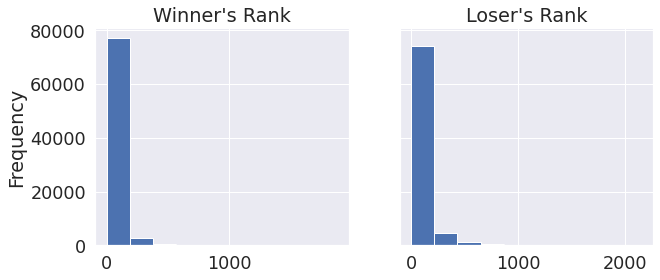

In [ ]:
#Create winner and loser rank histograms
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].hist(df['winner_rank'])
axs[0].set(title="Winner's Rank", ylabel='Frequency')
axs[1].hist(df['loser_rank'])
axs[1].set(title="Loser's Rank")
None

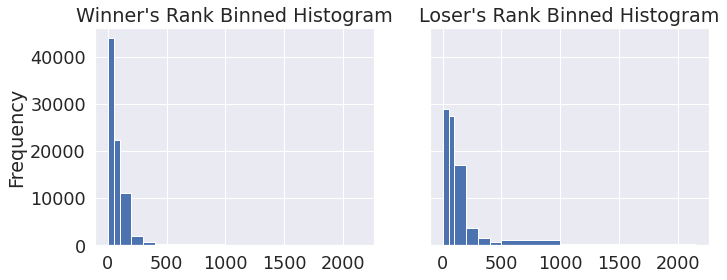

In [ ]:
#Bin the rank to create a better view of the frequency distribution
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11,4))
axs[0].hist(df['winner_rank'], bins=[1,50,100,200,300,400,500,1000,2159])
axs[0].set(title="Winner's Rank Binned Histogram", ylabel='Frequency')
axs[1].hist(df['loser_rank'], bins=[1,50,100,200,300,400,500,1000,2159])
axs[1].set(title="Loser's Rank Binned Histogram")
None

The loser and winner binned rank histograms above are consistent with the summary statistics seen above. The winner rank bin distribution is short tailed whereas the loser rank bin histogram is longer tailed therefore displaying the much worse ranks held by the losers. Both winner and loser distributions are positively skewed.

In [ ]:
#Create new columns of bins and difference between winner and loser ranks
bins=[1,50,100,200,300,400,500,1000,2159]
labels =[1,2,3,4,5,6,7,8]
rank['winner_bin'] = pd.cut(rank['winner_rank'], bins,labels=labels)
rank['loser_bin'] = pd.cut(rank['loser_rank'], bins,labels=labels)
rank['rank_diff'] = rank.winner_rank - rank.loser_rank
#Create lists from the dataframe columns
winner_rank = rank['winner_rank'].to_list()
loser_rank = rank['loser_rank'].to_list()
rank_diff = rank['rank_diff'].to_list()

As the rank distrubutions are skewed and non-normal,non-parametric tests will be used to test whether winners rank significantly better than losers

Wilcoxon signed rank test

𝐻0 : The median of the rank of winners is the same as that of losers


𝐻𝐴 : The median of the rank of winners is less (better) that of losers

In [ ]:
stats.wilcoxon(x=winner_rank, y=loser_rank, alternative='less')

WilcoxonResult(statistic=1009094359.5, pvalue=0.0)

Reject null hypothesis

In [ ]:
#if winner rank is lower (better player) then rank diff will be neg
#if winner_rank is higher than losers then rank diff will be postive
df['rank_difference'] = df['winner_rank'] - df['loser_rank']


#Higher_ranked are winners who had a better rank than the loser
higher_ranked = df[df['rank_difference'] < -1] #going wih -1 so I don't get matches where the rank was close
#lower_ranked are winners who had a lower rank than the winner
lower_ranked = df[df['rank_difference'] > 1]

## **2. Do higher ranked players win more matches against lower ranked players?**

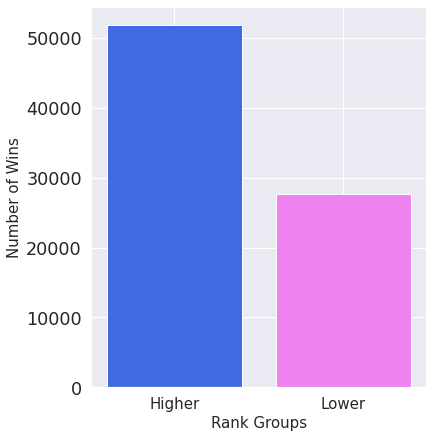

In [ ]:
high = len(higher_ranked)
low = len(lower_ranked)
Total = high + low
ranks = ['Higher', 'Lower']
wins = [high, low]
plt.figure(figsize=(6,7))
plt.bar(ranks, wins, color=['royalblue','violet'], zorder=1.6)
plt.ylabel('Number of Wins', fontsize=15)
plt.xlabel('Rank Groups', fontsize =15)
plt.grid(axis='y', zorder=0)
plt.xticks(fontsize=15)
None

In [ ]:
#Binomial Test to see if high ranked or low ranked players win more matches
pval = stats.binom_test(high, n=Total, p=0.5, alternative='greater')
if pval < 0.05:
    print(f'Reject null hypothesis. Higher ranked players won {round(100*(high/Total),2)}% of the matches against lower ranked players ({round(100*(low/Total),2)}%)')
    print(f'Thus, higher ranked players have the competitive advantage this difference is statistically significant ({pval} < 0.05)')
else:
  pval1 = stats.binom_test(low, n=Total, p=0.5, alternative='greater')
  print(f'Fail to reject null hypothesis. Lower ranked players won {round(100*(low/Total),2)}% of the matches against higher ranked players ({round(100*(high/Total),2)}%)')
  print(f'Thus, lower ranked players have the competitive advantage this difference is statistically significant ({pval1} < 0.05)')

Reject null hypothesis. Higher ranked players won 65.21% of the matches against lower ranked players (34.79%)
Thus, higher ranked players have the competitive advantage this difference is statistically significant (0.0 < 0.05)


## **3. Are higher ranked players overall better than lower ranked players?**

Approach:
- Compare high ranked winners who beat lower ranked competitors to lower ranked winners who beat higher ranked competitors and determined who scores more aces, commit fewer double faults, and has the more positive difference in breakpoints between saved & faced.  

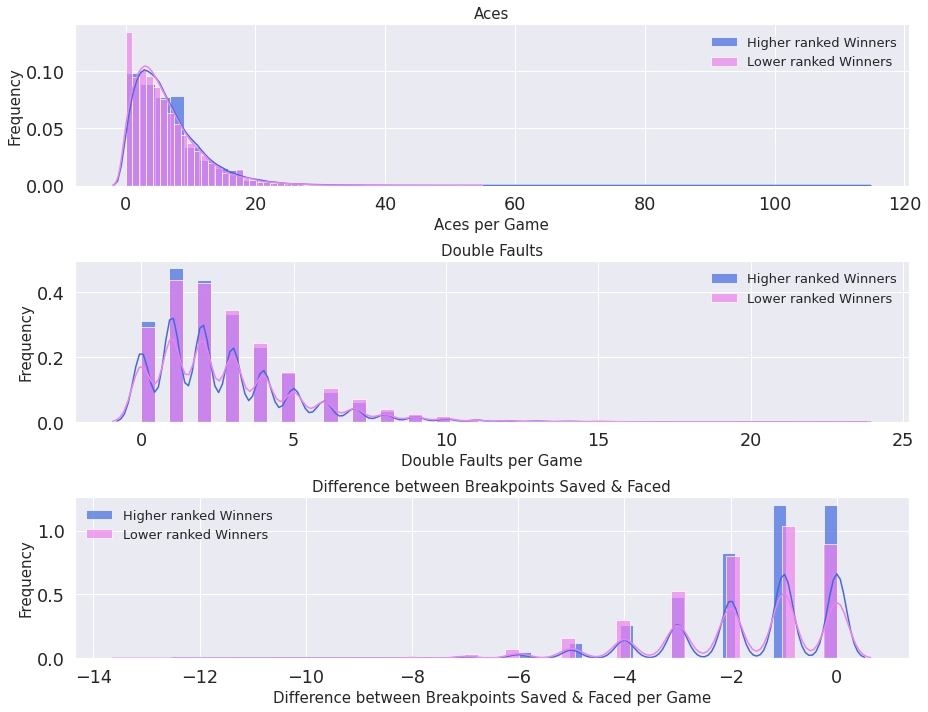

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference between Breakpoints Saved & Faced']
x_labels = ['Aces per Game', 'Double Faults per Game',
            'Difference between Breakpoints Saved & Faced per Game']
legend = ['Higher ranked Winners','Lower ranked Winners']
distribution_subplots(higher_ranked, lower_ranked, match_stats, titles, legend, x_labels)

In [ ]:
match_stats = ['w_ace','w_df','w_bp_difference']
titles = ['Aces', 'Double Faults', 'Difference in Breakpoints Saved & Faced']
median_names = ['Higher ranked Winners', 'Lower ranked Winners']
mann_whitney_u_test(higher_ranked, lower_ranked, match_stats, titles, median_names)

Title  Median for Higher ranked Winners  \
0                                     Aces                               5.0   
1                            Double Faults                               2.0   
2  Difference in Breakpoints Saved & Faced                              -1.0   

   Median for Lower ranked Winners  Mann-Whitney U Statistic        p-value  \
0                              5.0               744614802.5   8.775671e-19   
1                              2.0               690037483.0   6.276266e-20   
2                             -1.0               786809356.5  1.017905e-117   

                  Outcome  
0  Reject null hypothesis  
1  Reject null hypothesis  
2  Reject null hypothesis

From the resulting p-values, higher ranked winners scored overall more aces, committed fewer double faults, and had a more positive difference between breakpoints saved & faced than lower ranked winners

# Prediction Model:
Objective: Predict if a player (p1) would win against another player (p2), based on known input match and players info
- We will first define the input features and target feature we want to predict, ie, if p1 will win against p2.
- For this, we will split entire dataset into training & test datasets and train multiple supervised models to measure accuracy.

### **Approach**
- Transform dataset as match btw player p1 and p2. Here we will consider player p1 as winner_x and player p2 as loser_x. We will then add additional rows with same match info but player p1 as loser_x and player p2 as winner_x next.
- This transformed dataset should have info about the match (eg: surface, name, level, year, month, best_of) and the player p1 and p2 info (like rank, age, hand, ht, seed, country, rank_points)
- Label the data: output 'label' = 1 if player p1 is winner, 0 if player p2 loses.
- Perform encoding on the categorical features where needed and train a prediction model using the train set.
- We will try to use different prediction models like kNN, Logistic Regression, Decision Trees, Random Forest, XGBoost, etc. to compare accuracies with each model.

In [ ]:
df_1 = df.copy()
df_1.columns

Index(['best_of', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace',
       'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_name', 'loser_rank',
       'loser_rank_points', 'loser_seed', 'match_num', 'minutes', 'round',
       'score', 'surface', 'tourney_level', 'tourney_name', 'w_1stIn',
       'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved',
       'w_df', 'w_svpt', 'winner_age', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points',
       'winner_seed', 'tourney_month', 'tourney_year', 'w_bp_difference',
       'l_bp_difference', 'age_difference', 'ht_difference',
       'rank_difference'],
      dtype='object')

In [ ]:
#Making a copy of the dataset with features of interest
model_df = df_1[['best_of', 'surface','tourney_name','tourney_level',
                            'winner_rank', 'loser_rank','winner_age','loser_age','winner_ht','loser_ht',
                            'winner_hand','loser_hand','winner_seed','loser_seed','winner_ioc','loser_ioc',
                            'winner_rank_points','loser_rank_points']].copy()


In [ ]:
model_df

best_of surface    tourney_name tourney_level  winner_rank  \
76907         3    Hard  Sydney Outdoor             A         58.0   
76906         3    Hard  Sydney Outdoor             A        127.0   
76905         3    Hard  Sydney Outdoor             A         17.0   
76904         3    Hard  Sydney Outdoor             A         38.0   
76903         3    Hard  Sydney Outdoor             A         75.0   
...         ...     ...             ...           ...          ...   
169626        3    Hard        Acapulco             A         64.0   
169625        3    Hard        Acapulco             A          3.0   
169624        3    Hard        Acapulco             A         72.0   
169621        3    Hard        Acapulco             A         44.0   
169689        3    Clay       Sao Paulo             A         48.0   

        loser_rank  winner_age  loser_age  winner_ht    loser_ht winner_hand  \
76907         31.0       25.26      19.98   185.0000  188.000000           R   
76906         22.0       19.09      20.17   196.0000  201.000000           R   
76905         40.0       26.15      19.71   188.0000  190.000000           R   
76904         24.0       22.22      23.85   193.0000  188.000000           R   
76903         39.0       26.39      22.96   175.0000  190.000000           R   
...            ...         ...        ...        ...         ...         ...   
169626        71.0       23.51      23.86   184.2772  184.064918           L   
169625        26.0       21.85      20.02   198.0000  184.064918           R   
169624         2.0       23.83      32.73   193.0000  185.000000           R   
169621        87.0       29.70      29.62   183.0000  185.000000           R   
169689        92.0       28.78      22.74   185.0000  184.064918           L   

       loser_hand  winner_seed  loser_seed winner_ioc loser_ioc  \
76907           R          5.0         7.0        AUS       ESP   
76906           R          5.0         8.0        NED       SUI   
76905           R          4.0         7.0        SUI       SWE   
76904           L          5.0         7.0        GER       RUS   
76903           L          5.0         7.0        USA       CZE   
...           ...          ...         ...        ...       ...   
169626          R          5.0         7.0        GBR       USA   
169625          R          2.0         5.0        GER       AUS   
169624          L          5.0         1.0        AUS       ESP   
169621          R          8.0         7.0        AUS       GER   
169689          R          3.0         6.0        ARG       CHI   

        winner_rank_points  loser_rank_points  
76907                541.0              852.0  
76906                270.0              968.0  
76905               1089.0              694.0  
76904                721.0              929.0  
76903                474.0              706.0  
...                    ...                ...  
169626               797.0              753.0  
169625              6475.0             1443.0  
169624               750.0             8320.0  
169621              1008.0              640.0  
169689               975.0              620.0  

[80640 rows x 18 columns]

In [ ]:
#Relabelling the columns to reflect loser is p1 and winner is p2
model_df = model_df.rename(columns={"loser_rank": "p1_rank", "loser_age": "p1_age", "loser_ht": "p1_ht",
                                    "loser_hand": "p1_hand", "loser_seed": "p1_seed", "loser_ioc": "p1_ioc",
                                    "loser_rank_points": "p1_rank_points",
                                    "winner_rank": "p2_rank", "winner_age": "p2_age", "winner_ht": "p2_ht",
                                    "winner_hand": "p2_hand", "winner_seed": "p2_seed", "winner_ioc": "p2_ioc",
                                    "winner_rank_points": "p2_rank_points"})

Replicating rows with winner and loser columns interchanged as p1 and p2.

In [ ]:
#winner is p1 and loser is p2
model_df_p2 = model_df.copy()
model_df_p2[['best_of','surface','tourney_name','tourney_level',
             'p2_rank','p1_rank','p2_age','p1_age','p2_ht','p1_ht','p1_hand',
             'p2_hand','p2_seed','p1_seed','p2_ioc','p1_ioc','p2_rank_points','p1_rank_points']] = model_df_p2[['best_of','surface','tourney_name','tourney_level',
                                                  'p1_rank','p2_rank','p1_age','p2_age','p1_ht','p2_ht','p2_hand',
             'p1_hand','p1_seed','p2_seed','p1_ioc','p2_ioc','p1_rank_points','p2_rank_points']]

model_df_p2

best_of surface    tourney_name tourney_level  p2_rank  p1_rank  \
76907         3    Hard  Sydney Outdoor             A     31.0     58.0   
76906         3    Hard  Sydney Outdoor             A     22.0    127.0   
76905         3    Hard  Sydney Outdoor             A     40.0     17.0   
76904         3    Hard  Sydney Outdoor             A     24.0     38.0   
76903         3    Hard  Sydney Outdoor             A     39.0     75.0   
...         ...     ...             ...           ...      ...      ...   
169626        3    Hard        Acapulco             A     71.0     64.0   
169625        3    Hard        Acapulco             A     26.0      3.0   
169624        3    Hard        Acapulco             A      2.0     72.0   
169621        3    Hard        Acapulco             A     87.0     44.0   
169689        3    Clay       Sao Paulo             A     92.0     48.0   

        p2_age  p1_age       p2_ht     p1_ht p2_hand p1_hand  p2_seed  \
76907    19.98   25.26  188.000000  185.0000       R       R      7.0   
76906    20.17   19.09  201.000000  196.0000       R       R      8.0   
76905    19.71   26.15  190.000000  188.0000       R       R      7.0   
76904    23.85   22.22  188.000000  193.0000       L       R      7.0   
76903    22.96   26.39  190.000000  175.0000       L       R      7.0   
...        ...     ...         ...       ...     ...     ...      ...   
169626   23.86   23.51  184.064918  184.2772       R       L      7.0   
169625   20.02   21.85  184.064918  198.0000       R       R      5.0   
169624   32.73   23.83  185.000000  193.0000       L       R      1.0   
169621   29.62   29.70  185.000000  183.0000       R       R      7.0   
169689   22.74   28.78  184.064918  185.0000       R       L      6.0   

        p1_seed p2_ioc p1_ioc  p2_rank_points  p1_rank_points  
76907       5.0    ESP    AUS           852.0           541.0  
76906       5.0    SUI    NED           968.0           270.0  
76905       4.0    SWE    SUI           694.0          1089.0  
76904       5.0    RUS    GER           929.0           721.0  
76903       5.0    CZE    USA           706.0           474.0  
...         ...    ...    ...             ...             ...  
169626      5.0    USA    GBR           753.0           797.0  
169625      2.0    AUS    GER          1443.0          6475.0  
169624      5.0    ESP    AUS          8320.0           750.0  
169621      8.0    GER    AUS           640.0          1008.0  
169689      3.0    CHI    ARG           620.0           975.0  

[80640 rows x 18 columns]

In [ ]:
#Adding output labels. A new column for winning player label 'p1_label' (if p1 won) into each of the above 2 dfs

#In model_df loser is p1, so we will add 0 for 'p1_label' to indicate lose for p1
model_df['p1_label'] = np.zeros(model_df.shape[0])
model_df

#In model_df_p2, winner is p1, so we will add 1 for 'p1_label' to indicate win for p1
model_df_p2['p1_label'] = np.ones(model_df_p2.shape[0])
model_df_p2

best_of surface    tourney_name tourney_level  p2_rank  p1_rank  \
76907         3    Hard  Sydney Outdoor             A     31.0     58.0   
76906         3    Hard  Sydney Outdoor             A     22.0    127.0   
76905         3    Hard  Sydney Outdoor             A     40.0     17.0   
76904         3    Hard  Sydney Outdoor             A     24.0     38.0   
76903         3    Hard  Sydney Outdoor             A     39.0     75.0   
...         ...     ...             ...           ...      ...      ...   
169626        3    Hard        Acapulco             A     71.0     64.0   
169625        3    Hard        Acapulco             A     26.0      3.0   
169624        3    Hard        Acapulco             A      2.0     72.0   
169621        3    Hard        Acapulco             A     87.0     44.0   
169689        3    Clay       Sao Paulo             A     92.0     48.0   

        p2_age  p1_age       p2_ht     p1_ht p2_hand p1_hand  p2_seed  \
76907    19.98   25.26  188.000000  185.0000       R       R      7.0   
76906    20.17   19.09  201.000000  196.0000       R       R      8.0   
76905    19.71   26.15  190.000000  188.0000       R       R      7.0   
76904    23.85   22.22  188.000000  193.0000       L       R      7.0   
76903    22.96   26.39  190.000000  175.0000       L       R      7.0   
...        ...     ...         ...       ...     ...     ...      ...   
169626   23.86   23.51  184.064918  184.2772       R       L      7.0   
169625   20.02   21.85  184.064918  198.0000       R       R      5.0   
169624   32.73   23.83  185.000000  193.0000       L       R      1.0   
169621   29.62   29.70  185.000000  183.0000       R       R      7.0   
169689   22.74   28.78  184.064918  185.0000       R       L      6.0   

        p1_seed p2_ioc p1_ioc  p2_rank_points  p1_rank_points  p1_label  
76907       5.0    ESP    AUS           852.0           541.0       1.0  
76906       5.0    SUI    NED           968.0           270.0       1.0  
76905       4.0    SWE    SUI           694.0          1089.0       1.0  
76904       5.0    RUS    GER           929.0           721.0       1.0  
76903       5.0    CZE    USA           706.0           474.0       1.0  
...         ...    ...    ...             ...             ...       ...  
169626      5.0    USA    GBR           753.0           797.0       1.0  
169625      2.0    AUS    GER          1443.0          6475.0       1.0  
169624      5.0    ESP    AUS          8320.0           750.0       1.0  
169621      8.0    GER    AUS           640.0          1008.0       1.0  
169689      3.0    CHI    ARG           620.0           975.0       1.0  

[80640 rows x 19 columns]

In [ ]:
#Combining above datasets and randomly shuffling the rows before splitting into test & training sets
model = pd.concat([model_df, model_df_p2])
model = model.sample(frac=1).reset_index(drop=True)
model

best_of surface          tourney_name tourney_level  p2_rank  p1_rank  \
0             3  Carpet                Moscow             A     23.0     94.0   
1             3  Carpet                 Basel             A    185.0     17.0   
2             3    Hard             Hong Kong             A    116.0     80.0   
3             3    Clay       Hamburg Masters             M     17.0     49.0   
4             3    Hard  Indian Wells Masters             M     51.0     55.0   
...         ...     ...                   ...           ...      ...      ...   
161275        3    Hard            Washington             A     50.0    130.0   
161276        3    Hard               Memphis             A     24.0    108.0   
161277        3    Hard              Auckland             A     21.0    131.0   
161278        5    Hard               US Open             G     34.0     10.0   
161279        3    Hard  Indian Wells Masters             M     15.0     41.0   

        p2_age  p1_age     p2_ht       p1_ht p2_hand p1_hand  p2_seed  \
0        27.61   22.74  190.0000  180.000000       R       R      1.0   
1        27.90   24.19  183.0000  188.000000       R       R      4.0   
2        22.59   28.50  183.0000  175.000000       L       R      7.0   
3        23.66   24.54  185.0000  175.000000       R       L     12.0   
4        29.63   24.50  185.0000  188.000000       L       R      5.0   
...        ...     ...       ...         ...     ...     ...      ...   
161275   21.47   19.92  184.2772  184.064918       R       U      5.0   
161276   27.66   30.15  180.0000  185.000000       R       L      4.0   
161277   21.51   25.73  180.0000  185.000000       R       R      2.0   
161278   26.98   31.20  193.0000  188.000000       L       R      7.0   
161279   22.46   27.66  185.0000  183.000000       R       R     13.0   

        p1_seed p2_ioc p1_ioc  p2_rank_points  p1_rank_points  p1_label  
0           5.0    CZE    FRA          1089.0           424.0       0.0  
1           7.0    FRA    ECU           209.0          1321.0       0.0  
2           5.0    GER    ZIM           420.0           579.0       1.0  
3           5.0    GBR    MAR          1847.0           894.0       1.0  
4           7.0    FIN    UZB           957.0           906.0       0.0  
...         ...    ...    ...             ...             ...       ...  
161275      7.0    RUS    USA           902.0           428.0       0.0  
161276      5.0    USA    ARG          1384.0           422.0       1.0  
161277      7.0    RUS    RUS          1099.0           268.0       0.0  
161278     10.0    GBR    FRA           955.0          1871.0       1.0  
161279      5.0    RSA    USA          1603.0           819.0       1.0  

[161280 rows x 19 columns]

In [ ]:
#Checking for any missing values again
missing = model.isnull().sum().sort_values(ascending=False)
percent_missing = round((model_df.isnull().sum()/model_df.isnull().count())*100,1).sort_values(ascending=False)
missing_df = pd.concat([missing, percent_missing], axis=1, keys = ["Total","% Missing"])
missing_df

Total  % Missing
p1_label            0        0.0
p2_ht               0        0.0
surface             0        0.0
tourney_name        0        0.0
tourney_level       0        0.0
p2_rank             0        0.0
p1_rank             0        0.0
p2_age              0        0.0
p1_age              0        0.0
p1_ht               0        0.0
p1_rank_points      0        0.0
p2_hand             0        0.0
p1_hand             0        0.0
p2_seed             0        0.0
p1_seed             0        0.0
p2_ioc              0        0.0
p1_ioc              0        0.0
p2_rank_points      0        0.0
best_of             0        0.0

Encoding Categorical labels into Model-understandable numerical data:
- Will use sklearn labelEncoder class for this.
- Non-numerical features in dataset considered are Handedness, Country (ioc), surface, tourney level and name.

In [ ]:
#encoding categorical values like hand, country, surface, tourney_level, name
model['p1_hand'] = LabelEncoder().fit_transform(model['p1_hand'].astype(str))
model['p2_hand'] = LabelEncoder().fit_transform(model['p2_hand'].astype(str))
model['p1_ioc'] = LabelEncoder().fit_transform(model['p1_ioc'].astype(str))
model['p2_ioc'] = LabelEncoder().fit_transform(model['p2_ioc'].astype(str))
model['surface'] = LabelEncoder().fit_transform(model['surface'].astype(str))
model['tourney_level'] = LabelEncoder().fit_transform(model['tourney_level'].astype(str))
model['tourney_name'] = LabelEncoder().fit_transform(model['tourney_name'].astype(str))

model

best_of  surface  tourney_name  tourney_level  p2_rank  p1_rank  \
0             3        0           279              0     23.0     94.0   
1             3        0            13              0    185.0     17.0   
2             3        3           245              0    116.0     80.0   
3             3        1           242              4     17.0     49.0   
4             3        3           247              4     51.0     55.0   
...         ...      ...           ...            ...      ...      ...   
161275        3        3           357              0     50.0    130.0   
161276        3        3           270              0     24.0    108.0   
161277        3        3             9              0     21.0    131.0   
161278        5        3           349              3     34.0     10.0   
161279        3        3           247              4     15.0     41.0   

        p2_age  p1_age     p2_ht       p1_ht  p2_hand  p1_hand  p2_seed  \
0        27.61   22.74  190.0000  180.000000        1        1      1.0   
1        27.90   24.19  183.0000  188.000000        1        1      4.0   
2        22.59   28.50  183.0000  175.000000        0        1      7.0   
3        23.66   24.54  185.0000  175.000000        1        0     12.0   
4        29.63   24.50  185.0000  188.000000        0        1      5.0   
...        ...     ...       ...         ...      ...      ...      ...   
161275   21.47   19.92  184.2772  184.064918        1        2      5.0   
161276   27.66   30.15  180.0000  185.000000        1        0      4.0   
161277   21.51   25.73  180.0000  185.000000        1        1      2.0   
161278   26.98   31.20  193.0000  188.000000        0        1      7.0   
161279   22.46   27.66  185.0000  183.000000        1        1     13.0   

        p1_seed  p2_ioc  p1_ioc  p2_rank_points  p1_rank_points  p1_label  
0           5.0      22      31          1089.0           424.0       0.0  
1           7.0      31      25           209.0          1321.0       0.0  
2           5.0      34      95           420.0           579.0       1.0  
3           5.0      32      55          1847.0           894.0       1.0  
4           7.0      30      91           957.0           906.0       0.0  
...         ...     ...     ...             ...             ...       ...  
161275      7.0      74      90           902.0           428.0       0.0  
161276      5.0      90       1          1384.0           422.0       1.0  
161277      7.0      74      74          1099.0           268.0       0.0  
161278     10.0      32      31           955.0          1871.0       1.0  
161279      5.0      73      90          1603.0           819.0       1.0  

[161280 rows x 19 columns]

In [ ]:
#Split model data into two groups: train & test. Here, we split in 70:30 ratio
y = model['p1_label'] #prediction output
x = model.drop(columns='p1_label') #input predictor features

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)


### **Classification Models**

#### **1. KNN**
KNeighbors classification model looks at the nearest neighbors and uses euclidean distance for finding the proximity between neighboring points and then votes for the most frequent nearest label or averages the labels.

In [ ]:
from sklearn import metrics
# we will pick k such that accuracy is optimal
k_range = range(1,20)
scores = {}
scores_list = []
for k in k_range:
   knn_classifier = KNeighborsClassifier(n_neighbors=k)
   knn_classifier.fit(x_train, y_train)
   knn_prediction = knn_classifier.predict(x_test)
   scores[k] = metrics.accuracy_score(y_test,knn_prediction)
   scores_list.append(metrics.accuracy_score(y_test,knn_prediction))

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,knn_prediction))
print("Classification Report:")
print(classification_report(y_test,knn_prediction))
print("KNN: Accuracy score = ", round(accuracy_score(y_test, knn_prediction), 3))

Confusion Matrix:
[[15132  8924]
 [ 8971 15357]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.63      0.63     24056
         1.0       0.63      0.63      0.63     24328

    accuracy                           0.63     48384
   macro avg       0.63      0.63      0.63     48384
weighted avg       0.63      0.63      0.63     48384

KNN: Accuracy score =  0.63


In [ ]:
plt.plot(k_range,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
None

k = 10 seems optimal beyond which accuracy doesn't improve drastically at higher k.

In [ ]:
#Fitting a KNN model with k = 10
knn_classifier = KNeighborsClassifier(10)
knn_classifier.fit(x_train, y_train)
knn_prediction = knn_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,knn_prediction))
print("Classification Report:")
print(classification_report(y_test,knn_prediction))
print("KNN: Accuracy score = ", round(accuracy_score(y_test, knn_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
knn_acc_train = accuracy_score(y_train, knn_classifier.predict(x_train))
knn_acc_test = accuracy_score(y_test, knn_prediction)

print("train: ", knn_acc_train)
print("test: ", knn_acc_test)

Confusion Matrix:
[[16683  7373]
 [11230 13098]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64     24056
         1.0       0.64      0.54      0.58     24328

    accuracy                           0.62     48384
   macro avg       0.62      0.62      0.61     48384
weighted avg       0.62      0.62      0.61     48384

KNN: Accuracy score =  0.616
train:  0.6932752267573696
test:  0.6155133928571429


KNN model accuracy on train is higher than test. Test set accuracy is only 60%. This model seems to be underfitting and not performing very well in general.

#### **2. Logistic Regression**

In [ ]:
#Fitting an logistic regression model
lr_classifier = LogisticRegression()
lr_classifier.fit(x_train, y_train)
lr_prediction = lr_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,lr_prediction))
print("Classification Report:")
print(classification_report(y_test,lr_prediction))
print("Logistic Regression: Accuracy score = ", round(accuracy_score(y_test, lr_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
lr_acc_train = accuracy_score(y_train, lr_classifier.predict(x_train))
lr_acc_test = accuracy_score(y_test, lr_prediction)

print("train: ", lr_acc_train)
print("test: ", lr_acc_test)

Confusion Matrix:
[[16477  7579]
 [ 7503 16825]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69     24056
         1.0       0.69      0.69      0.69     24328

    accuracy                           0.69     48384
   macro avg       0.69      0.69      0.69     48384
weighted avg       0.69      0.69      0.69     48384

Logistic Regression: Accuracy score =  0.688
train:  0.6860119047619048
test:  0.6882853835978836


Logistic Regression model is only slightly better than KNN but the test accuracy is only at 68% and underfitting.

#### **3. Naives Bayes**

In [ ]:
#Fitting a Naives Bayes model
nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)
nb_prediction = nb_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,nb_prediction))
print("Classification Report:")
print(classification_report(y_test,nb_prediction))
print("NB: Accuracy score = ", round(accuracy_score(y_test, nb_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
nb_acc_train = accuracy_score(y_train, nb_classifier.predict(x_train))
nb_acc_test = accuracy_score(y_test, nb_prediction)

print("train: ", nb_acc_train)
print("test: ", nb_acc_test)

Confusion Matrix:
[[17427  6629]
 [ 7036 17292]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72     24056
         1.0       0.72      0.71      0.72     24328

    accuracy                           0.72     48384
   macro avg       0.72      0.72      0.72     48384
weighted avg       0.72      0.72      0.72     48384

NB: Accuracy score =  0.718
train:  0.7128241921768708
test:  0.7175719246031746


Naives Bayes model accuracy on train is almost similar to that of test set. But Test set accuracy is only 72%. This model seems to be underfitting and not very strong in accurately predicting match winner.

#### **4. Decision Tree**
Decision tree is a flowchart like tree structure where each node represents a feature, the branch a decision rule and leaf node representing the outcome.
- max_depth shows the maximum number of nodes along the longest path from the root node down to the farthest leaf node.

In [ ]:
#Fitting a Decision Tree model
decisiontree_classifier = DecisionTreeClassifier(max_depth=4)
decisiontree_classifier.fit(x_train, y_train)
decisiontree_prediction = decisiontree_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,decisiontree_prediction))
print("Classification Report:")
print(classification_report(y_test,decisiontree_prediction))
print("Decision Tree: Accuracy score = ", round(accuracy_score(y_test, decisiontree_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
dt_acc_train = accuracy_score(y_train, decisiontree_classifier.predict(x_train))
dt_acc_test = accuracy_score(y_test, decisiontree_prediction)

print("train: ", dt_acc_train)
print("test: ", dt_acc_test)


Confusion Matrix:
[[21967  2089]
 [ 3362 20966]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     24056
         1.0       0.91      0.86      0.88     24328

    accuracy                           0.89     48384
   macro avg       0.89      0.89      0.89     48384
weighted avg       0.89      0.89      0.89     48384

Decision Tree: Accuracy score =  0.887
train:  0.8872767857142857
test:  0.8873387896825397


Decision Tree model accuracy on train is almost similar to that on test. Test set accuracy is at 88%. This model seems to be performing fairly well.

#### **5. Random Forest**
RandomForest Classifier model takes the training dataset to build decision trees. This model builds multiple such decision trees and combines them together to get accurate predictions.

There are 3 key attributes to improve this model:  
1.   max_features: Maximum number of features random forest tries in individual tree. This can be all features, square root of total number of features or x% of features to be considered.
2.   n_estimators: Number of trees to build before taking the aggregate of predictions. Higher number of n_estimators can give better performance but is also slower.
3.   min_sample_leaf: Leaf is the end node of a decision tree. Smaller leaf makes the model prone to noise in training set.

In [ ]:
#Fitting a randomforest model
randomforest_classifier = RandomForestClassifier(n_estimators=4, max_depth = 5)
randomforest_classifier.fit(x_train, y_train)
randomforest_prediction = randomforest_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,randomforest_prediction))
print("Classification Report:")
print(classification_report(y_test,randomforest_prediction))
print("RandomForest: Accuracy score = ", round(accuracy_score(y_test, randomforest_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
rf_acc_train = accuracy_score(y_train, randomforest_classifier.predict(x_train))
rf_acc_test = accuracy_score(y_test, randomforest_prediction)

print("train: ", rf_acc_train)
print("test: ", rf_acc_test)

Confusion Matrix:
[[22357  1699]
 [ 2335 21993]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     24056
         1.0       0.93      0.90      0.92     24328

    accuracy                           0.92     48384
   macro avg       0.92      0.92      0.92     48384
weighted avg       0.92      0.92      0.92     48384

RandomForest: Accuracy score =  0.917
train:  0.9159491921768708
test:  0.9166253306878307


RandomForest model accuracy on train is almost similar to that on test. Test set accuracy can be upto 90%. This model seems to be performing fairly well. We can further play around with n_estimator and max_depth values for making the prediction model stronger but can cause overfitting or get slower at higher values.

#### **6. XGBoost**
XGBoost is an implementation of gradient boosted decision trees usually known to have higher speed and performance.

In [ ]:
#Fitting an XGBoost classification model
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)
xgb_prediction = xgb_classifier.predict(x_test)

#print confusion matrix and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test,xgb_prediction))
print("Classification Report:")
print(classification_report(y_test,xgb_prediction))
print("XGBoost: Accuracy score = ", round(accuracy_score(y_test, xgb_prediction), 3))

# #accuracy of model on train & test used to see later if model is overfitting
xgb_acc_train = accuracy_score(y_train, xgb_classifier.predict(x_train))
xgb_acc_test = accuracy_score(y_test, xgb_prediction)

print("train: ", xgb_acc_train)
print("test: ", xgb_acc_test)

Confusion Matrix:
[[22885  1171]
 [ 1177 23151]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     24056
         1.0       0.95      0.95      0.95     24328

    accuracy                           0.95     48384
   macro avg       0.95      0.95      0.95     48384
weighted avg       0.95      0.95      0.95     48384

XGBoost: Accuracy score =  0.951
train:  0.9524872448979592
test:  0.9514715608465608


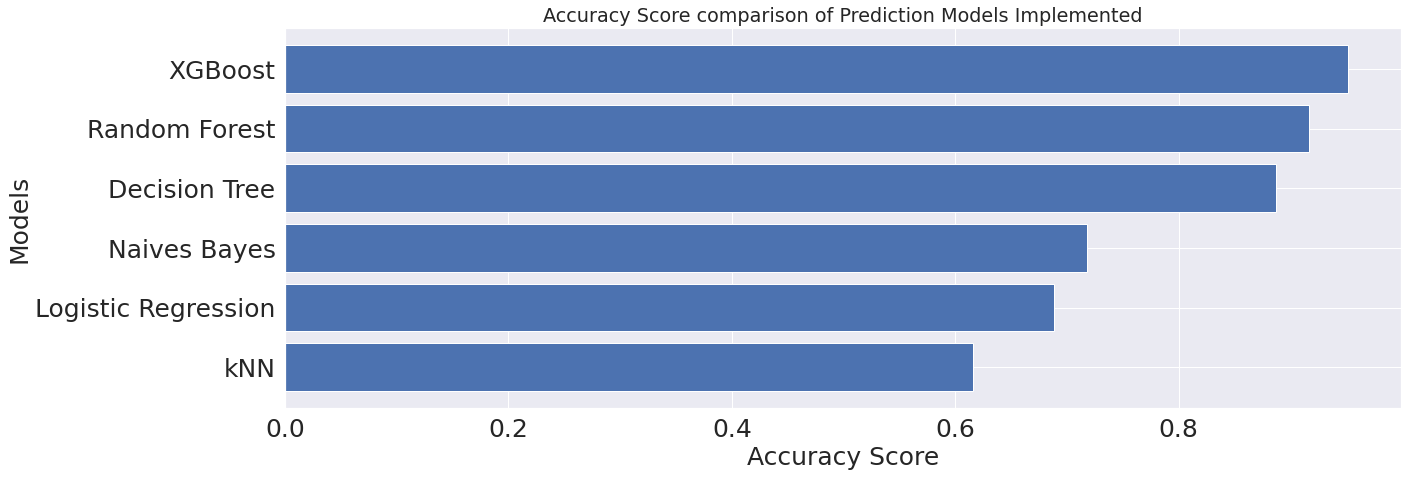

In [ ]:
models = ['kNN', 'Logistic Regression','Naives Bayes','Decision Tree','Random Forest', 'XGBoost']
accuracy_scores = [knn_acc_test, lr_acc_test, nb_acc_test, dt_acc_test, rf_acc_test, xgb_acc_test]
plt.figure(figsize=(20,7))
plt.barh(models, accuracy_scores)
plt.xlabel('Accuracy Score', fontsize=25)
plt.ylabel('Models', fontsize=25)
#plt.grid(axis='y', zorder=0)
plt.title('Accuracy Score comparison of Prediction Models Implemented')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.savefig('MC.png',bbox_inches='tight')
None

### **Feature Importance**

Based on the high accuracy score of the XGBoost model, we measured the importance of each feature within the model.

In [ ]:
#Fitting an XGBoost classification model
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)
xgb_prediction = xgb_classifier.predict(x_test)

#feature importance
feature_important = xgb_classifier.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

#plot important features by score
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
plt.figure(figsize=(15,7))
data['score'].plot(kind='barh')
plt.xlabel('Importance Score', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.savefig('MC.png',bbox_inches='tight')
None


XGBoost model shows that the features match surface, player's seed, player's rank, and rank points weigh higher in terms of importance. These features more strongly influence the prediction.